<a href="https://colab.research.google.com/github/tomik062/AI_Project/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

install and import all libraries

In [1]:
!pip install dowhy
import requests
import os
import importlib.util
import pandas as pd
import numpy as np
import statsmodels.api as sm
import logging
import warnings
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split,GridSearchCV, LeaveOneOut,KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso,ElasticNet, Ridge
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from dowhy import CausalModel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.2/399.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 10.6 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.2
    Uninstalling scipy-1.16.2:
      Successfully uninstalled scipy-1.16.2
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.6.7
    Uninstalling cvxpy-1.6.7:
      Successfully uninstalled cvxpy-1.6.7


extract data from github and merge together

In [2]:
# Define the GitHub details
def init_process():
  repo_owner = 'tomik062'
  repo_name = 'AI_Project'
  file_path = 'extract_data.py'
  url = f'https://raw.githubusercontent.com/{repo_owner}/{repo_name}/main/{file_path}'

  # Directory to save the downloaded file
  download_dir = 'data_extraction_code'
  if not os.path.exists(download_dir):
      os.makedirs(download_dir)

  local_file_path = os.path.join(download_dir, file_path)

  # Download the file
  response = requests.get(url)
  response.raise_for_status() # Raise an exception for bad status codes

  with open(local_file_path, 'wb') as f:
      f.write(response.content)

  print(f"Downloaded {file_path} to {local_file_path}")

  # Import the function from the downloaded file
  spec = importlib.util.spec_from_file_location("extract_data_module", local_file_path)
  module = importlib.util.module_from_spec(spec)
  spec.loader.exec_module(module)
  # Call the extract_data function and print the output
  return module.extract_data()

In [3]:
def calc_features_year(data,year):
    feature_map = {
        'urbanization': 0,
        'avg birth age': 1,
        'happiness index': 2,
        'health expenditure': 3,
        'physicians per capita': 4,
        'GNI PPP': 5,
        'female labor participation': 6,
        'christians (%)': 7,
        'muslims (%)': 8,
        'no religion (%)': 9,
        'buddhists (%)': 10,
        'hindus (%)': 11,
        'jews (%)': 12,
        'other religion (%)': 13,
        'in Asia-Pacific':14,
        'in Europe':15,
        'in Latin America-Caribbean':16,
        'in Middle East-North Africa':17,
        'in North America':18,
        'in Sub-Saharan Africa':19,
        'post-HS education men (%)': 20,
        'post-HS education women (%)': 21,
        'human development index': 22,
        'gender inequality index': 23,
        'first marriage age women': 24,
        'first marriage age men': 25,
        'maternity leave index': 26,
        'work hours men': 27,
        'work hours women': 28,
        'abortion rate': 29,
        'social media users': 30
    }
    countries_with_data = sorted(list(set([key[0] for key in data.keys() if key[1] == year])))
    index = pd.MultiIndex.from_product([countries_with_data, [year]], names=['country', 'year'])
    df = pd.DataFrame(index=index, columns=feature_map.keys())
    target=[]
    # Populate the DataFrame
    for (country, yr) in index:
        key = (country, yr)
        features = data[key][1]
        target.append(data[key][0])
        for feature_name, feature_index in feature_map.items():
            if feature_index < len(features):
              df.loc[key, feature_name] = features[feature_index]
              if str(features[feature_index]) =='nan':
                df.loc[key, feature_name]=handle_missing_values(data,feature_index,country,year)
    return df,target



def handle_missing_values(data, feature_index, country, year):
    # try taking the value from the last 2 years
    for i in range(1, 3):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and str(past_data[feature_index])!='nan':
                return past_data[feature_index]

    # otherwise if missing last 2 years, linearly extrapulate from last 6 years
    recent_years_data = []
    for i in range(6,0,-1):
        past_year = year - i
        if (country, past_year) in data:
            past_data = data[(country, past_year)][1] # Access the list of features
            if feature_index < len(past_data) and not pd.isna(past_data[feature_index]):
                 recent_years_data.append((past_year, past_data[feature_index]))

    if len(recent_years_data) >= 2:
        years = [item[0] for item in recent_years_data]
        values = [item[1] for item in recent_years_data]
        last_value = values[-1]
        # Linear extrapolation using linear regression with polyfit
        try:
            m, c = np.polyfit(years, values, 1)
            extrapolated_value = m * year + c

            # Check if extrapolated value is within 50% of last value
            if last_value != 0 and abs(extrapolated_value - last_value) / abs(last_value) > 0.3:
                return last_value
            elif last_value == 0 and abs(extrapolated_value) > 0.3 * np.mean(values): # Handle edge case where last_value is 0
                 return last_value
            else:
                return extrapolated_value
        except np.linalg.LinAlgError:
            # Handle cases where polyfit fails (e.g., all years are the same)
            return last_value # Return the last known value
    elif len(recent_years_data) == 1:
         # If only one data point in the last 10 years, use that value
         return recent_years_data[0][1]

    # If still missing after checking last 10 years, return NaN
    return np.nan

In [4]:
def find_missing_features(df_features):

  # Identify countries with and without NaN values
  countries_with_nan = df_features[df_features.isnull().any(axis=1)].index.tolist()
  countries_without_nan = df_features.dropna().index.tolist()
  countries_with_one_nan = df_features[df_features.isnull().sum(axis=1) == 1].index.tolist()

  # Print the results
  print("Countries with NaN values in their features:")
  print(countries_with_nan)
  print("\nCountries without NaN values in their features:")
  print(countries_without_nan)
  print("\nCountries with exactly one NaN value in their features:")
  print(countries_with_one_nan)

  print(f"\nNumber of countries with NaN values: {len(countries_with_nan)}")
  print(f"Number of countries without NaN values: {len(countries_without_nan)}")
  print(f"Number of countries with exactly one NaN value: {len(countries_with_one_nan)}")

  # Group countries by their single missing feature
  missing_features_grouped = {}
  if countries_with_one_nan:
      for country in countries_with_one_nan:
          missing_feature_name = df_features.loc[country].isnull().idxmax()
          if missing_feature_name not in missing_features_grouped:
              missing_features_grouped[missing_feature_name] = []
          missing_features_grouped[missing_feature_name].append(str(country))

      # Print countries grouped by missing feature
      print("\nMissing feature for countries with exactly one NaN:")
      for feature, countries in missing_features_grouped.items():
          print(f"  Missing feature is '{feature}':")
          print(f"    Countries: {', '.join(countries)}")

process all the data, and fill some missing data using 2 methods

In [5]:
def process_2023_data(data_output):
    df_features, target = calc_features_year(data_output, 2023)
    missing_values_to_fill = {
        'abortion rate': {
            'Cyprus': 7,'Ireland': 6.7,'Malaysia': 11,
            'Mauritania': 42,'Malta': 3,'Morocco': 25, 'Congo, Rep.': 39
        },
        'maternity leave index': {
            'Albania': 23.23,'Bosnia and Herzegovina': 52.14,
            'Kazakhstan': 18,'Georgia': 7.59,'Kyrgyz Republic': 18,
            'Moldova': 18,'Angola': 13,'Armenia': 20,
            'Azerbaijan': 18,'Malawi': 12.86,'Bhutan': 8,
            'Tanzania': 12,'Tajikistan': 20,'North Macedonia': 39,
            'Liberia': 12.86,'Suriname': 0,'Uzbekistan': 18
        },
        'gender inequality index':{
            'Central African Republic':0.682
        },
        'physicians per capita':{
            'Somalia': 0.048, 'Viet Nam': 1.25
        }
    }

    # Fill in missing values using the dictionary
    for feature, country_values in missing_values_to_fill.items():
        for country, value in country_values.items():
            if (country,2023) in df_features.index:
                df_features.loc[(country,2023), feature] = value


    df_features = df_features.apply(pd.to_numeric, errors='coerce')
    y = pd.Series(target, index=df_features.index, name='target')
    combined_df = pd.concat([df_features, y], axis=1)
    combined_df_cleaned = combined_df.dropna()
    X = combined_df_cleaned.drop('target', axis=1)
    y = combined_df_cleaned['target']

    return X,y

def process_multi_year_data(data_output):
  years = [2023, 2007, 1991]
  all_features = []
  all_targets = []

  for year in years:
      df_features, target = calc_features_year(data_output, year)
      df_features['year'] = year
      all_features.append(df_features)
      all_targets.extend(target)

  X = pd.concat(all_features)
  y = pd.Series(all_targets, index=X.index, name='target')

  columns_to_drop = [
      'christians (%)', 'muslims (%)', 'no religion (%)', 'buddhists (%)',
      'hindus (%)', 'jews (%)', 'other religion (%)', 'gender inequality index',
      'happiness index', 'first marriage age women', 'first marriage age men',
      'work hours men', 'work hours women', 'social media users', 'abortion rate',
      'health expenditure' ,'maternity leave index'
  ]

  X = X.drop(columns=columns_to_drop)
  X = X.apply(pd.to_numeric, errors='coerce')
  # Add specific missing data points (structured by feature)
  missing_values_to_fill_manual = {
      'GNI PPP': {
          ('Venezuela, RB', 2023): 20017,
          ('Syrian Arab Republic', 2007): 3914.3,
          ('Nigeria', 2007): 3260.8,
          ('Afghanistan', 1991): 1070
      },
      'female labor participation': {
          ('Grenada', 2023): 51.42
      },
      'physicians per capita': {
          ('Hong Kong SAR, China', 2023): 2.1,
          ('Hong Kong SAR, China', 2007): 1.13,
          ('India', 2007): 0.61
      },
      'urbanization': {
          ('West Bank and Gaza', 2023): 77.58,
          ('West Bank and Gaza', 2007): 73.49,
          ('Montenegro', 2023): 68.5,
          ('Montenegro', 2007): 63.14,
          ('Maldives', 2023): 42.41,
          ('Maldives', 2007): 35.2,
          ('Serbia', 2023): 57.11,
          ('Serbia', 2007): 54.33
      },
      'human development index': {
          ('Sudan', 2007): 0.526,
          ('Rwanda', 1991): 0.213,
          ('Sao Tome and Principe', 1991): 0.399,
          ('Ethiopia', 1991): 0.166
      }
  }

  for feature, country_year_values in missing_values_to_fill_manual.items():
      if feature in X.columns:
          for (country, year), value in country_year_values.items():
              if (country, year) in X.index:
                  X.loc[(country, year), feature] = value
  combined_df = pd.concat([X, y], axis=1)
  combined_df_cleaned = combined_df.dropna()
  X = combined_df_cleaned.drop('target', axis=1)
  y = combined_df_cleaned['target']

  return X,y

plot destribution histograms

In [6]:
def plot_features(X_train):

  # Get the list of columns
  columns = X_train.columns

  # Calculate the number of rows needed
  n_cols = 5
  n_rows = math.ceil(len(columns) / n_cols)

  # Create subplots
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 5))
  axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

  # Plot histograms for all features
  for i, column in enumerate(columns):
      axes[i].hist(X_train[column], bins=10)
      axes[i].set_title(f'Histogram of {column}')
      axes[i].set_xlabel(column)
      axes[i].set_ylabel('Frequency')
      axes[i].grid(True)

  # Hide any unused subplots
  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

pipeline classes to prepare data

In [7]:
class Scaling2023(BaseEstimator, TransformerMixin):
    def __init__(self,log_features=None,features_to_scale=None,health_features=None):
        self.log_features=log_features or ['no religion (%)','other religion (%)','buddhists (%)','hindus (%)','jews (%)','GNI PPP']
        self.health_features=health_features or ['physicians per capita','health expenditure']
        self.features_to_scale=features_to_scale or [
            'urbanization','avg birth age','happiness index','GNI PPP','female labor participation','christians (%)','muslims (%)','no religion (%)',
            'buddhists (%)','hindus (%)','jews (%)','other religion (%)','post-HS education men (%)','post-HS education women (%)',
            'human development index','gender inequality index','first marriage age women','first marriage age men','maternity leave index',
            'work hours men','work hours women','abortion rate','social media users','healthcare index'
        ]
        self.health_scaler=StandardScaler()
        self.scaler=StandardScaler()

    def fit(self,X,y=None):
        X_copy=X.copy()
        missing=[c for c in (self.health_features+self.log_features) if c not in X_copy.columns]
        if missing: raise KeyError(f"Missing columns: {missing}")

        self.health_scaler.fit(X_copy[self.health_features])
        h_scaled=self.health_scaler.transform(X_copy[self.health_features])
        score=h_scaled[:,0]+h_scaled[:,1]
        X_copy=X_copy.drop(columns=self.health_features)
        X_copy['healthcare index']=score
        for f in self.log_features:
            X_copy[f]=pd.to_numeric(X_copy[f])
            X_copy[f]=np.log1p(X_copy[f])
        self.scaler.fit(X_copy[self.features_to_scale])
        return self

    def transform(self,X):
        X_copy=X.copy()
        h_scaled=self.health_scaler.transform(X_copy[self.health_features])
        score=h_scaled[:,0]+h_scaled[:,1]
        X_copy=X_copy.drop(columns=self.health_features)
        X_copy['healthcare index']=score
        for f in self.log_features:
            X_copy[f]=pd.to_numeric(X_copy[f])
            X_copy[f]=np.log1p(X_copy[f])
        X_copy[self.features_to_scale]=self.scaler.transform(X_copy[self.features_to_scale])
        return X_copy

class ScalingMultiYear(BaseEstimator, TransformerMixin):
    def __init__(self,log_features=None,features_to_scale=None):
        self.log_features=log_features or ['GNI PPP','physicians per capita']
        self.features_to_scale=features_to_scale or [
            'urbanization','avg birth age','GNI PPP',
            'female labor participation','post-HS education men (%)',
            'post-HS education women (%)','human development index',
            'physicians per capita'
        ]
        self.scaler=StandardScaler()

    def fit(self,X,y=None):
        X_copy=X.copy()
        self.scaler.fit(X_copy[self.features_to_scale])
        return self

    def transform(self,X):
        X_copy=X.copy()
        for f in self.log_features:
            X_copy[f]=pd.to_numeric(X_copy[f])
            X_copy[f]=np.log1p(X_copy[f])
        X_copy[self.features_to_scale]=self.scaler.transform(X_copy[self.features_to_scale])
        return X_copy

In [8]:
def create_health_index_score(X_train,X_test):
    scaler_healthcare = StandardScaler()
    health_features = ['physicians per capita','health expenditure']
    X_train[health_features] = scaler_healthcare.fit_transform(X_train[health_features])
    X_test[health_features] = scaler_healthcare.transform(X_test[health_features])
    X_train['healthcare index'] = X_train['physicians per capita'] + X_train['health expenditure']
    X_test['healthcare index'] = X_test['physicians per capita'] + X_test['health expenditure']
    X_train = X_train.drop(['physicians per capita', 'health expenditure'], axis=1)
    X_test = X_test.drop(['physicians per capita', 'health expenditure'], axis=1)
    return X_train,X_test

calculate and plot correlations, and mutual information

In [9]:
def feature_correlations(df, method):
    """Calculates and visualizes correlation matrix, and prints top 5 correlated pairs."""

    correlation_matrix = df.corr(method=method)

    plt.figure(figsize=(18, 15))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
    plt.title(f'{method.capitalize()} Correlation Heatmap of Features in train set')
    plt.show()

    print(f"\nTop 5 most highly correlated pairs of features (absolute {method.capitalize()} correlation):")
    upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    stacked_corr = upper_tri.stack().sort_values(ascending=False, key=abs)
    top_5_correlated_pairs = stacked_corr.head(5)

    for (feature1, feature2), correlation in top_5_correlated_pairs.items():
        print(f"  {feature1} and {feature2}: {correlation:.4f}")


In [10]:
def analyze_target_correlation(X, y, method_name, alpha_threshold=0.001):
    combined_data = pd.concat([X, y], axis=1)
    correlation_series = combined_data.corr(method=method_name)['target'].drop('target').sort_values(ascending=False)

    p_values = {}
    correlations = {}

    for feature in correlation_series.index:
        if method_name == 'pearson':
            corr, p_value = stats.pearsonr(combined_data[feature], combined_data['target'])
        elif method_name == 'spearman':
            corr, p_value = stats.spearmanr(combined_data[feature], combined_data['target'])

        correlations[feature] = corr
        p_values[feature] = p_value

    correlation_series = pd.Series(correlations).loc[correlation_series.index]
    p_value_series = pd.Series(p_values).loc[correlation_series.index]

    plt.figure(figsize=(12, 8))
    sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')
    plt.title(f'{method_name} Correlation of Features with fertility rate')
    plt.xlabel(f'{method_name} Correlation Coefficient')
    plt.ylabel('Features')
    plt.show()

    print(f"\n{method_name} Correlation with fertility rate (with p-values and alpha={alpha_threshold}):")
    for feature, corr in correlation_series.items():
        p_value = p_value_series.loc[feature]
        p_value_str = "p<.001" if p_value < alpha_threshold else f"p={p_value:.3f}"
        print(f"  {feature}: {corr:.4f} ({p_value_str})")
    return correlation_series

In [11]:
def analyze_mutual_information(X, y):
    """Calculates and displays Mutual Information scores of features with the target."""
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    print("Mutual Information Scores of Features with fertility rate:")
    print(mi_scores)
    plt.figure(figsize=(10, 6))
    sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')
    plt.title('Mutual Information Scores of Features with fertility rate')
    plt.xlabel('Mutual Information Score')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()
    return mi_scores

perform grid searches for the best models

In [12]:
def gridsearch_loocv_lasso(X,y,scaler):
    pipe=Pipeline([('scaler',scaler),('lasso',Lasso(fit_intercept=True))])
    param_grid={'lasso__alpha':[val*(10**i) for i in range(-3,3) for val in [1,3]]}
    gs=GridSearchCV(pipe,param_grid,cv=LeaveOneOut(),scoring='neg_mean_squared_error',n_jobs=-1)
    gs.fit(X,y)
    return gs

def gridsearch_ridge_loocv(X,y,scaler):
    pipe=Pipeline([('scaler',scaler),('ridge',Ridge(fit_intercept=True))])
    param_grid={
        'ridge__alpha':[val*(10**i) for i in range(-3,3) for val in [1,3]]
    }
    gs=GridSearchCV(pipe,param_grid,cv=LeaveOneOut(),scoring='neg_mean_squared_error',n_jobs=-1)
    gs.fit(X,y)
    return gs

def gridsearch_random_forest(X,y,scaler):
  pipe=Pipeline([('scaler',scaler),('rf',RandomForestRegressor(random_state=42,n_jobs=-1))])
  kf=KFold(n_splits=5,shuffle=True,random_state=42)
  param_grid = {
        'rf__n_estimators': [10, 25, 100, 400],
        'rf__max_depth': [2, 4 , 6, None],
        'rf__min_samples_split': [2, 3 , 5, 9],
        'rf__min_samples_leaf': [1, 2, 4, 6],
        'rf__max_features': ['sqrt', 0.5, 1.0],
    }
  gs=GridSearchCV(pipe,param_grid,cv=kf,scoring='neg_mean_squared_error',n_jobs=-1)
  gs.fit(X,y)
  return gs


def gridsearch_xgboost(X, y,scaler):
    pipe = Pipeline([
        ('scaler', scaler),
        ('xgb', XGBRegressor(tree_method='hist',random_state=42,n_jobs=-1,importance_type='gain'))])
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    param_grid = {
        'xgb__n_estimators': [10, 25, 100, 400],
        'xgb__learning_rate': [0.001, 0.01 , 0.1,0.5],
        'xgb__max_depth': [1, 2, 4],
        'xgb__min_child_weight': [1, 10],
        'xgb__subsample': [0.7],#decrease overfit
        'xgb__colsample_bytree': [0.7],#decrease overfit
        'xgb__gamma': [0, 1],
        'xgb__reg_alpha': [0, 1],
        'xgb__reg_lambda': [1,10],

    }
    gs=GridSearchCV(pipe,param_grid,cv=kf,scoring='neg_mean_squared_error',n_jobs=-1)
    gs.fit(X,y)
    return gs

def report_grid_search(gs,X,y,model,scaler):
  best_est = gs.best_estimator_
  names = best_est.named_steps['scaler'].transform(X).columns
  idx = gs.best_index_
  cv_mse = -gs.cv_results_['mean_test_score'][idx]
  print(f"Best params: {gs.best_params_}")
  print(f"CV MSE: {cv_mse:.4f} (±{gs.cv_results_['std_test_score'][idx]:.4f})")
  print("Train accuracy:")
  accuracy_report(best_est,X,y)
  est = best_est.named_steps[model]

  if model in ['lasso','ridge']:
    coefs = pd.Series(est.coef_, index=names)
    coefs = coefs.reindex(coefs.abs().sort_values(ascending=False).index)
    print("\ncoefficients:")
    for f,c in coefs.items():
      print(f"{f}: {c:.4f}")
  else:#random forest or xgboost
    if model=='rf':
      print("\nmean decrease in imputirty by feature:")
    if model=='xgb':
      print("\nmean gain by feature:")
    imp = pd.Series(est.feature_importances_, index=names).sort_values(ascending=False)
    for f,v in imp.items():
      print(f"{f}: {v:.4f}")

In [20]:
from sklearn.metrics import mean_squared_error, r2_score

def gridsearch_all_models(X_train,y_train,scaler):
  print('\nlasso regressor:')
  lasso_gs = gridsearch_loocv_lasso(X_train,y_train, scaler)
  report_grid_search(lasso_gs,X_train,y_train,'lasso', scaler)
  print('\nridge regressor:')
  ridge_gs = gridsearch_ridge_loocv(X_train,y_train, scaler)
  report_grid_search(ridge_gs,X_train,y_train,'ridge', scaler)
  print('\nrandom forest regressor:')
  rf_gs = gridsearch_random_forest(X_train,y_train, scaler)
  report_grid_search(rf_gs,X_train,y_train,'rf', scaler)
  print('\nxgboost regressor:')
  xgb_gs = gridsearch_xgboost(X_train,y_train, scaler)
  report_grid_search(xgb_gs,X_train,y_train,'xgb', scaler)
  return lasso_gs, ridge_gs, rf_gs, xgb_gs


def accuracy_report(estimator,X,y):
  y_pred=estimator.predict(X)
  mse=mean_squared_error(y,y_pred)
  r2=r2_score(y,y_pred)
  print(f"MSE: {mse:.4f}")
  print(f"R-squared: {r2:.4f}")


def compare_predictions(estimator, X, y):
  y_pred = estimator.predict(X)
  comparison_df = pd.DataFrame({'Actual': y, 'Predicted': y_pred}, index=X.index)
  for index, row in comparison_df.iterrows():
      print(f"For: {index}, Actual: {row['Actual']:.4f}, Predicted: {row['Predicted']:.4f}")

def plot_feature_importance_comparison(Pearson_corr, Spearman_corr, MI_scores, lasso_gs, ridge_gs, rf_gs, xgb_gs, X_train):
    """
    Plots a comparison of various feature importance metrics.
    """
    # Collect data
    scaler = lasso_gs.best_estimator_.named_steps['scaler'] # Get scaler from one pipeline
    feature_names = scaler.transform(X_train).columns

    lasso_coefs = pd.Series(lasso_gs.best_estimator_.named_steps['lasso'].coef_, index=feature_names)
    ridge_coefs = pd.Series(ridge_gs.best_estimator_.named_steps['ridge'].coef_, index=feature_names)
    rf_importances = pd.Series(rf_gs.best_estimator_.named_steps['rf'].feature_importances_, index=feature_names)
    xgb_importances = pd.Series(xgb_gs.best_estimator_.named_steps['xgb'].feature_importances_, index=feature_names)

    # Consolidate data
    importance_df = pd.DataFrame({
        'Pearson Corr': Pearson_corr, 'Spearman Corr': Spearman_corr, 'Mutual Info': MI_scores,
        'Lasso Coef': lasso_coefs, 'Ridge Coef': ridge_coefs,
        'RF MDI': rf_importances, 'XGB Gain': xgb_importances
    }).fillna(0)

    # Normalize data
    scaler = MinMaxScaler()
    importance_df_abs_scaled = pd.DataFrame(scaler.fit_transform(importance_df.abs()), columns=importance_df.columns, index=importance_df.index)

    # Structure data for plotting
    importance_melted = importance_df_abs_scaled.reset_index().melt(id_vars='index', var_name='Metric', value_name='Scaled Importance (Absolute)').rename(columns={'index': 'Feature'})

    # Create visualization
    n_features = len(feature_names)
    n_cols = 5
    n_rows = (n_features + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4), squeeze=False)
    axes = axes.flatten()

    for i, feature in enumerate(feature_names):
        sns.barplot(x='Metric', y='Scaled Importance (Absolute)', hue='Metric', data=importance_melted[importance_melted['Feature'] == feature], ax=axes[i], palette='viridis', legend=False)
        axes[i].set_title(feature); axes[i].set_xlabel(''); axes[i].set_ylabel('Scaled Importance'); axes[i].tick_params(axis='x', rotation=45); axes[i].set_ylim(0, 1)


    for j in range(i + 1, len(axes)): fig.delaxes(axes[j])
    plt.tight_layout(); plt.suptitle('Comparison of Feature Importance Metrics (Scaled Absolute Values)', y=1.02, fontsize=16); plt.show()

combine all of the experiments

In [14]:
def exec_experiments(data,isMultiYear):
  if isMultiYear:
    X,y = process_multi_year_data(data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    unscaled_X_train=X_train.copy()
    unscaled_X_test=X_test.copy()
    scaler = ScalingMultiYear()
    full_data_scaler=ScalingMultiYear()
  else:#is only 2023
    X,y = process_2023_data(data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    unscaled_X_train,unscaled_X_test = create_health_index_score(X_train.copy(),X_test.copy())
    scaler = Scaling2023()
    full_data_scaler=Scaling2023()

  print('unscaled features')
  plot_features(unscaled_X_train)
  scaler.fit(X_train)
  scaled_train = scaler.transform(X_train)
  scaled_test = scaler.transform(X_test)
  print('scaled and transformed features')
  plot_features(scaled_train)

  #feature pairs correlations
  full_data_scaler.fit(X)
  scaled_full_data = full_data_scaler.transform(X)
  print('\nfeature pairs correlations:')
  feature_correlations(scaled_train, 'pearson')
  feature_correlations(scaled_train, 'spearman')
  #feature-target correlations and mutual information
  Pearson_corr=analyze_target_correlation(scaled_full_data, y, 'pearson')
  Spearman_corr=analyze_target_correlation(scaled_full_data, y, 'spearman')
  MI_scores=analyze_mutual_information(scaled_full_data, y)
  #run grid search of cv on all models
  lasso_gs, ridge_gs, rf_gs, xgb_gs = gridsearch_all_models(X_train,y_train, scaler)

  # Calculate and print test MSE for each model,
  print("testing trained models signal strength using test set:")
  print('\nlasso regressor final results:')
  accuracy_report(lasso_gs.best_estimator_,X_test,y_test)
  print('\nridge regressor final results:')
  accuracy_report(ridge_gs.best_estimator_,X_test,y_test)
  print('\nrandom forest regressor final results:')
  accuracy_report(rf_gs.best_estimator_,X_test,y_test)
  print('\nxgboost regressor final results:')
  accuracy_report(xgb_gs.best_estimator_,X_test,y_test)

  #plot feature importance comparison
  plot_feature_importance_comparison(Pearson_corr, Spearman_corr, MI_scores, lasso_gs, ridge_gs, rf_gs, xgb_gs, X_train)
  return X_train, X_test, y_train, y_test, lasso_gs, ridge_gs, rf_gs, xgb_gs

subgroups experiment

In [15]:
def prep_subgroups(isMultiYear=False):
  data = {
      'Feature/Target': [
          'target',
          'urbanization',
          'avg birth age',
          'happiness index',
          'health expenditure',
          'physicians per capita',
          'GNI PPP',
          'female labor participation',
          'christians (%)',
          'muslims (%)',
          'no religion (%)',
          'buddhists (%)',
          'hindus (%)',
          'jews (%)',
          'other religion (%)',
          'in Asia-Pacific',
          'in Europe',
          'in Latin America-Caribbean',
          'in Middle East-North Africa',
          'in North America',
          'in Sub-Saharan Africa',
          'post-HS education men (%)',
          'post-HS education women (%)',
          'human development index',
          'gender inequality index',
          'first marriage age women',
          'first marriage age men',
          'maternity leave index',
          'work hours men',
          'work hours women',
          'abortion rate',
          'social media users'
      ],
      'Haredim': [
          6.4, 91.53, 31.3, 7.341, 4008, 3.713, 29213, 81, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 1, 0, 0, 4.2, 14, 0.847, 0.525, 22, 23, 14, 36.5, 32.5, 8.1, 0.32
      ],
      'Non Haredim jews': [
          2.5, 74.26, 31.3, 7.341, 4008, 3.713, 51498, 83, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 1, 0, 0, 31.3, 45.1, 0.959, 0.043, 28, 30, 14, 45, 38.5, 8.1, 0.911
      ],
      'Arabs': [
          2.75, 42.5, 27.7, 7.341, 4008, 3.713, 29420, 33.7, 7.7, 83.3, 0, 0, 0, 0, 9, 0, 0, 0, 1, 0, 0, 10.8, 23.3, 0.856, 0.237, 23.11, 26.96, 14, 43.4, 36.5, 5.99, 0.7128
      ]
  }

  # Create DataFrame
  df = pd.DataFrame(data)

  # Transpose the DataFrame so that the first column becomes the index and the other columns become rows
  df_transposed = df.set_index('Feature/Target').T

  # Separate the target variable as a Series
  target_series = df_transposed['target']
  features_df = df_transposed.drop(columns=['target'])

  if isMultiYear:
      multi_year_features = [
          'urbanization',
          'avg birth age',
          'physicians per capita',
          'GNI PPP',
          'female labor participation',
          'in Asia-Pacific',
          'in Europe',
          'in Latin America-Caribbean',
          'in Middle East-North Africa',
          'in North America',
          'in Sub-Saharan Africa',
          'post-HS education men (%)',
          'post-HS education women (%)',
          'human development index',
      ]
      features_df = features_df[multi_year_features].copy()
      features_df['year'] = 2023

  return features_df, target_series

In [16]:
def test_subgroups(data,isMultiYear):
  if isMultiYear:
    X_train,y_train = process_multi_year_data(data)
    scaler=ScalingMultiYear()
  else:
    X_train,y_train = process_2023_data(data)
    scaler=Scaling2023()
  X_test,y_test= prep_subgroups(isMultiYear)
  if ('Israel', 2023) in X_train.index:
    israel_X_2023 = X_train.loc[('Israel', 2023)].to_frame().T
    israel_y_2023 = pd.Series(y_train.loc[('Israel', 2023)], index=israel_X_2023.index, name=y_train.name)
    X_test = pd.concat([X_test, israel_X_2023])
    y_test = pd.concat([y_test, israel_y_2023])
    X_train = X_train.drop(('Israel', 2023))
    y_train = y_train.drop(('Israel', 2023))


  lasso_gs, ridge_gs, rf_gs, xgb_gs = gridsearch_all_models(X_train,y_train, scaler)

  print("testing model accuracy on sub groups")
  print('\nlasso regressor results for subgroups:')
  compare_predictions(lasso_gs.best_estimator_,X_test,y_test)
  print('\nridge regressor final results:')
  compare_predictions(ridge_gs.best_estimator_,X_test,y_test)
  print('\nrandom forest regressor final results:')
  compare_predictions(rf_gs.best_estimator_,X_test,y_test)
  print('\nxgboost regressor final results:')
  compare_predictions(xgb_gs.best_estimator_,X_test,y_test)

causal inference experiment

In [17]:
def test_causal_effects(df, outcome):
    X_causal = df.copy()
    features_to_log = [
      'christians (%)','muslims (%)','no religion (%)','buddhists (%)',
      'hindus (%)','jews (%)','other religion (%)','GNI PPP'
    ]

    for feature in features_to_log:
        if feature in X_causal.columns:
            X_causal[feature] = pd.to_numeric(X_causal[feature])
            X_causal[feature] = np.log1p(X_causal[feature])
    print("\ntesting causal effect of social media usage")
    analyze_causal_effect(X_causal, outcome, 'social media users')

def analyze_causal_effect(df, outcome, treatment):
    controls = [c for c in ('urbanization','GNI PPP','first marriage age women','avg birth age','maternity leave index',
          'muslims (%)','jews (%)','no religion (%)','buddhists (%)','hindus (%)','other religion (%)',
          'in Asia-Pacific','in Europe','in Latin America-Caribbean','in Middle East-North Africa','in North America') if c in df.columns]
    data = pd.concat([df[[treatment]+controls], outcome], axis=1).apply(pd.to_numeric, errors='coerce')
    #supressing internal dowhy warning spam
    logging.getLogger("dowhy").setLevel(logging.ERROR)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Series.__getitem__ treating keys as positions is deprecated")
        warnings.filterwarnings("ignore", category=FutureWarning, module=r".*dowhy.*")

        model = CausalModel(data=data, treatment=treatment, outcome=outcome.name, common_causes=controls)
        ie = model.identify_effect()
        est = model.estimate_effect(ie, method_name="backdoor.linear_regression")

        X = sm.add_constant(data[[treatment]+controls]); Y = data[outcome.name]
        ols = sm.OLS(Y, X).fit(); l, h = ols.conf_int().loc[treatment]
        print(f"coef={ols.params[treatment]:.4f}, CI=[{l:.4f},{h:.4f}], Change in fertility caused by a 10% increase in social media usage={0.1*ols.params[treatment]:.4f}")

        #run robustness checks
        print("\nRunning robustness checks:")

        # Placebo Treatment Refuter
        placebo = model.refute_estimate(ie, est, method_name="placebo_treatment_refuter", random_state=42)
        print(f"Placebo Test: {placebo.refutation_result}")


        # Random Common Cause Refuter
        random_cause = model.refute_estimate(ie, est, method_name="random_common_cause", random_state=42)
        print(f"Random Common Cause Test: {random_cause.refutation_result}")

main code- runs everything

Downloaded extract_data.py to data_extraction_code/extract_data.py
Downloaded GNI_PPP_const_2021_dollars.csv to data/GNI_PPP_const_2021_dollars.csv
Downloaded Religious-Composition-percentages.csv to data/Religious-Composition-percentages.csv
Downloaded abortion-rates-by-country-2025.csv to data/abortion-rates-by-country-2025.csv
Downloaded age-at-first-marriage-by-country-2025.csv to data/age-at-first-marriage-by-country-2025.csv
Downloaded average-workweek-by-country-2025.csv to data/average-workweek-by-country-2025.csv
Downloaded female-labor-force-participation-rates-slopes.csv to data/female-labor-force-participation-rates-slopes.csv
Downloaded female-labor-participation.csv to data/female-labor-participation.csv
Downloaded gender-inequality-index.xlsx to data/gender-inequality-index.xlsx
Downloaded happiness-cantril-ladder.csv to data/happiness-cantril-ladder.csv
Downloaded healthcare-expenditure-per-capita-ppp.csv to data/healthcare-expenditure-per-capita-ppp.csv
Downloaded high

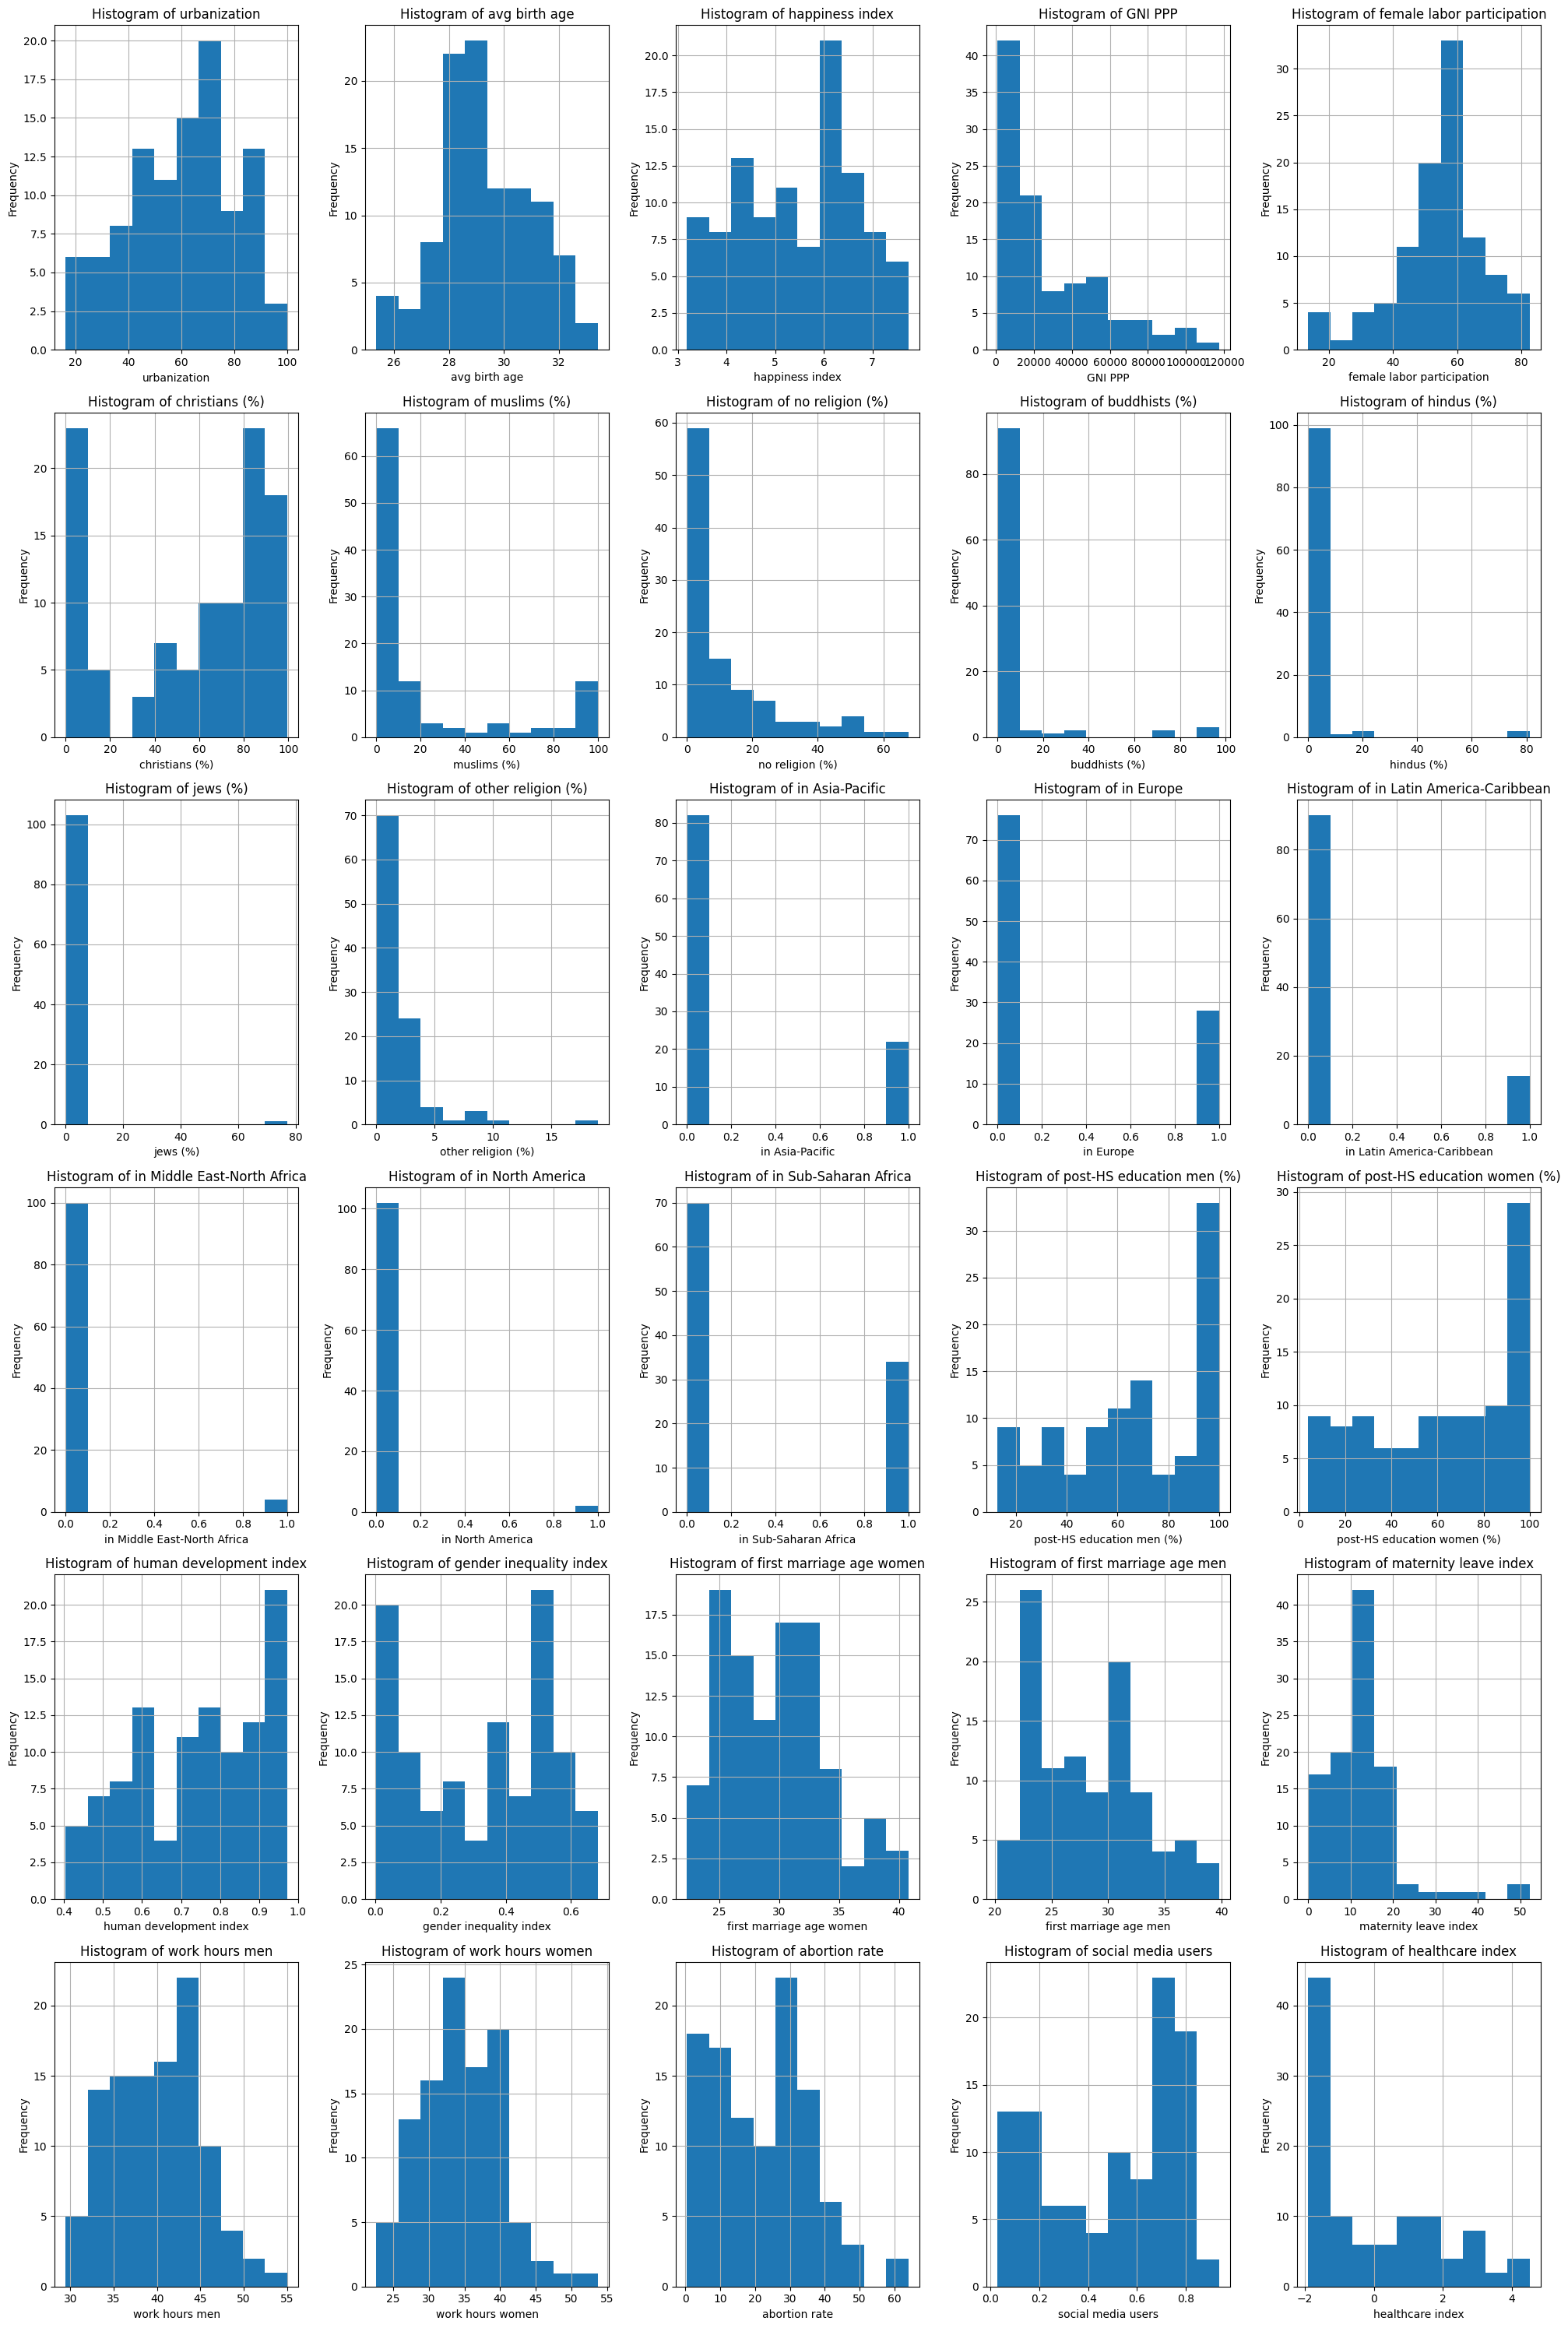

scaled and transformed features


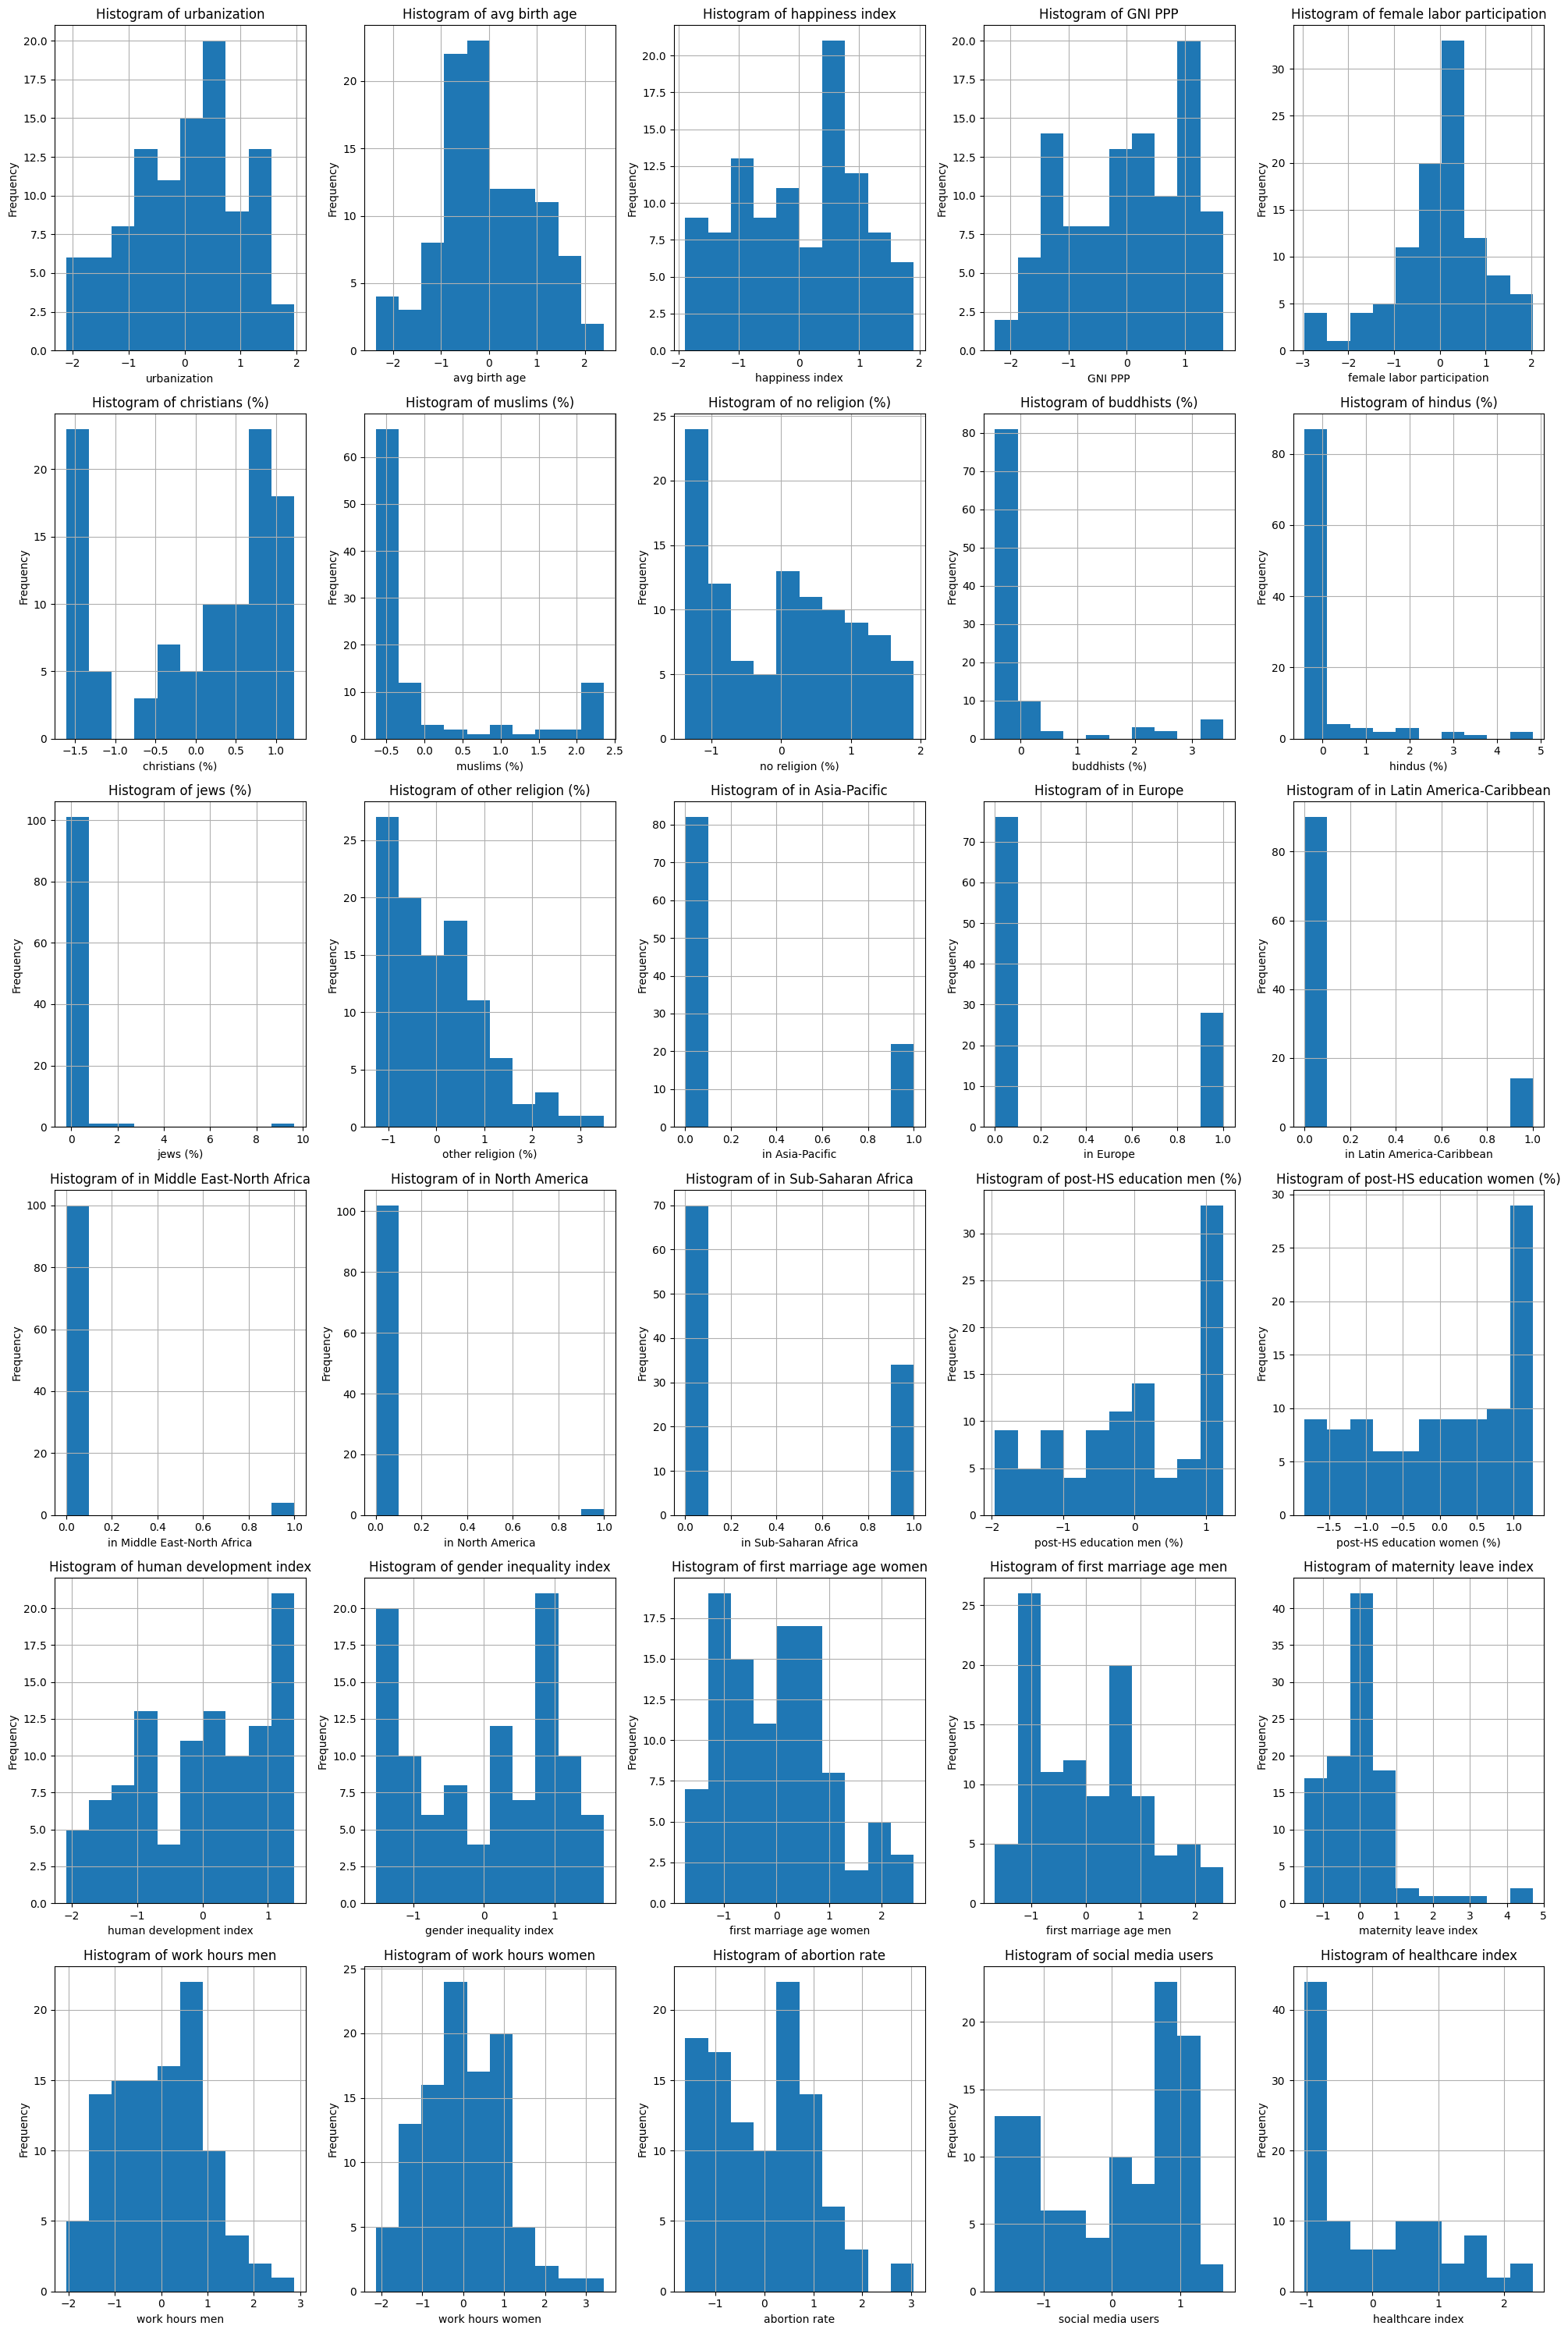


feature pairs correlations:


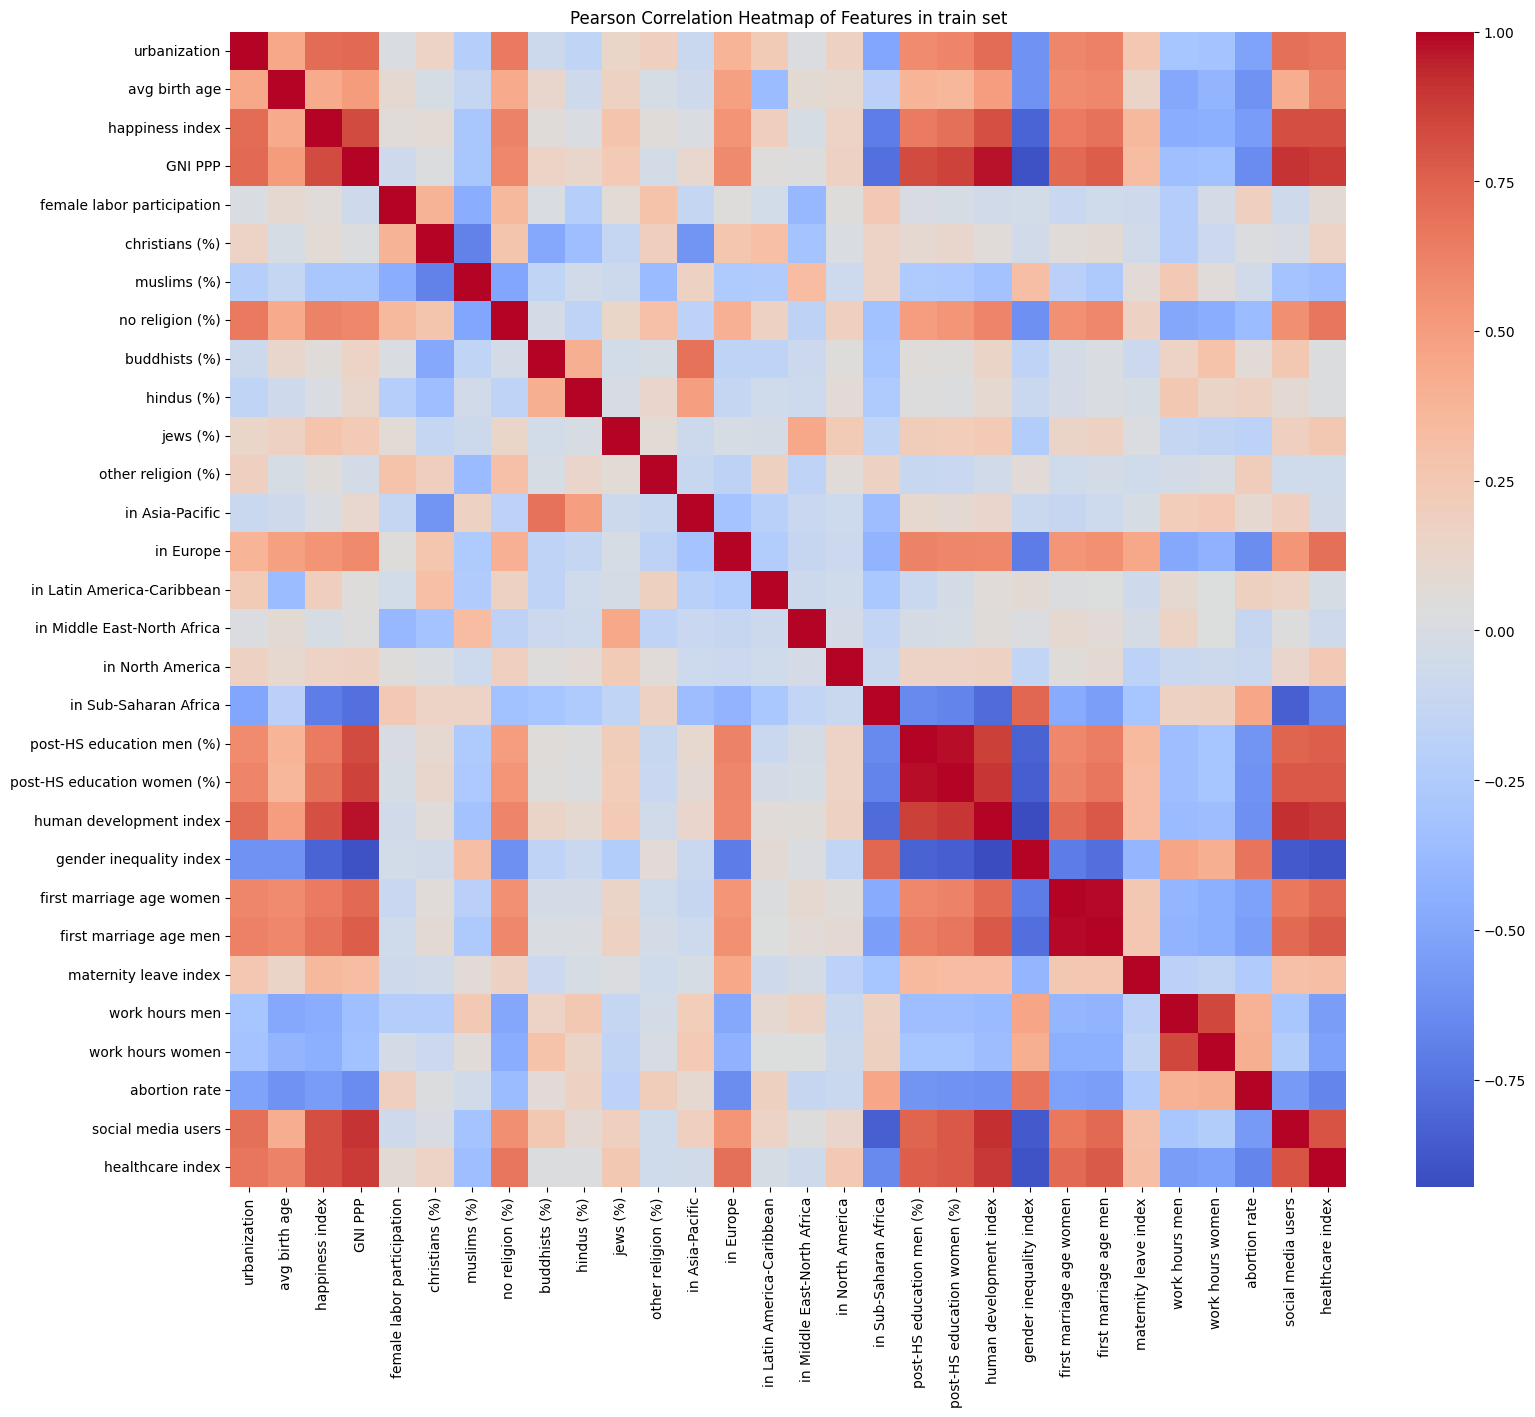


Top 5 most highly correlated pairs of features (absolute Pearson correlation):
  first marriage age women and first marriage age men: 0.9888
  post-HS education men (%) and post-HS education women (%): 0.9811
  GNI PPP and human development index: 0.9754
  human development index and gender inequality index: -0.9283
  human development index and social media users: 0.9166


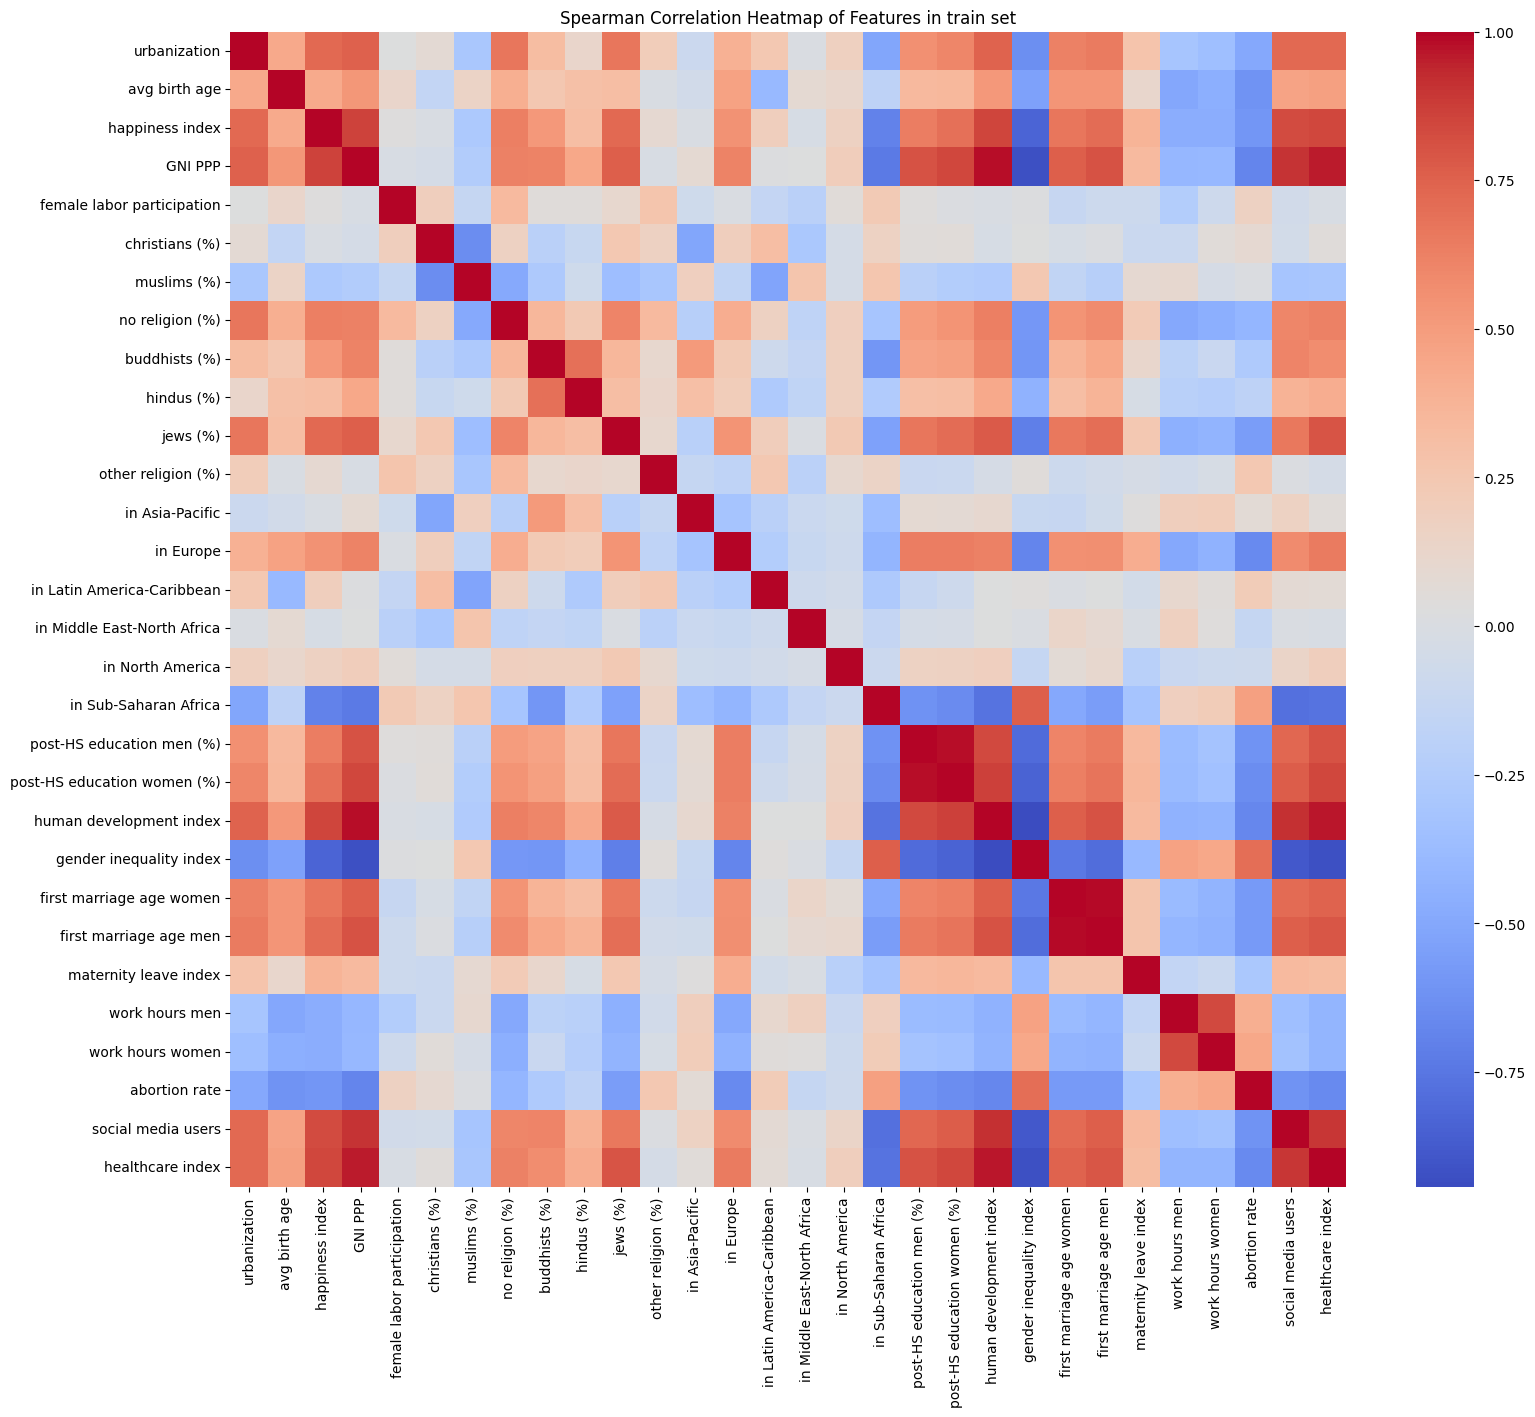


Top 5 most highly correlated pairs of features (absolute Spearman correlation):
  first marriage age women and first marriage age men: 0.9851
  post-HS education men (%) and post-HS education women (%): 0.9822
  GNI PPP and human development index: 0.9821
  human development index and healthcare index: 0.9683
  GNI PPP and healthcare index: 0.9578


/tmp/ipython-input-249271996.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


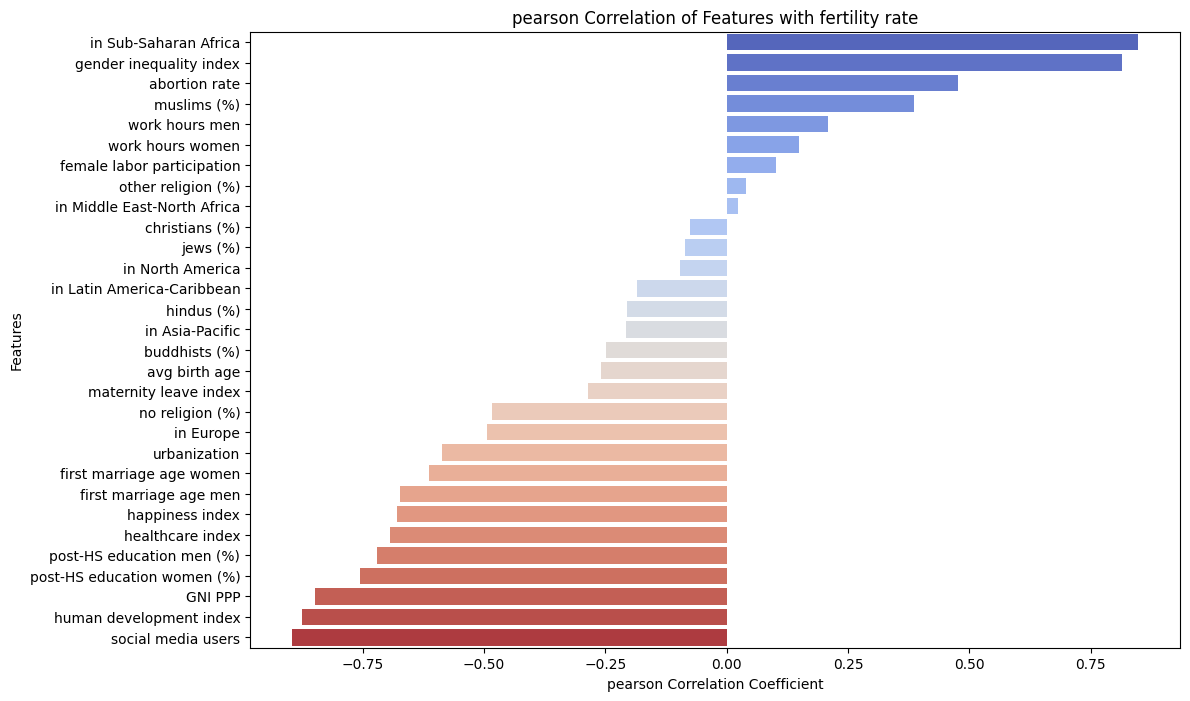


pearson Correlation with fertility rate (with p-values and alpha=0.001):
  in Sub-Saharan Africa: 0.8469 (p<.001)
  gender inequality index: 0.8151 (p<.001)
  abortion rate: 0.4765 (p<.001)
  muslims (%): 0.3853 (p<.001)
  work hours men: 0.2081 (p=0.017)
  work hours women: 0.1483 (p=0.091)
  female labor participation: 0.1026 (p=0.244)
  other religion (%): 0.0404 (p=0.647)
  in Middle East-North Africa: 0.0230 (p=0.794)
  christians (%): -0.0761 (p=0.388)
  jews (%): -0.0855 (p=0.331)
  in North America: -0.0967 (p=0.272)
  in Latin America-Caribbean: -0.1856 (p=0.034)
  hindus (%): -0.2058 (p=0.018)
  in Asia-Pacific: -0.2080 (p=0.017)
  buddhists (%): -0.2489 (p=0.004)
  avg birth age: -0.2598 (p=0.003)
  maternity leave index: -0.2853 (p<.001)
  no religion (%): -0.4832 (p<.001)
  in Europe: -0.4937 (p<.001)
  urbanization: -0.5862 (p<.001)
  first marriage age women: -0.6136 (p<.001)
  first marriage age men: -0.6738 (p<.001)
  happiness index: -0.6791 (p<.001)
  healthcare ind

/tmp/ipython-input-249271996.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


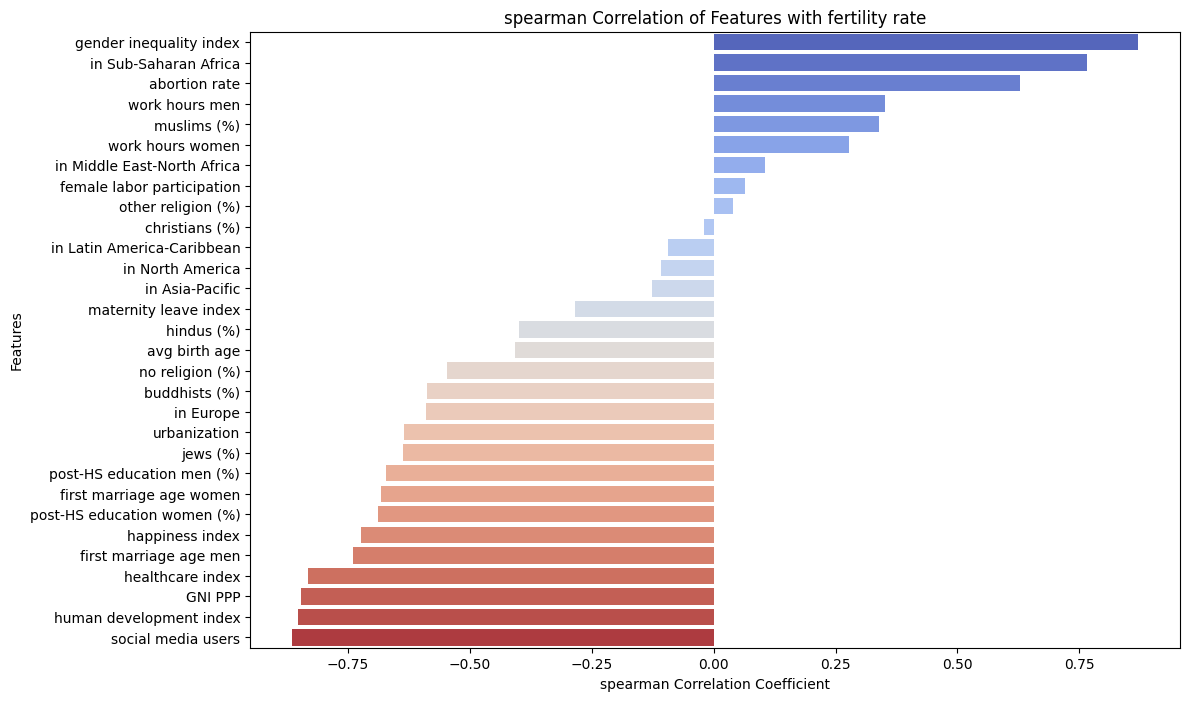


spearman Correlation with fertility rate (with p-values and alpha=0.001):
  gender inequality index: 0.8698 (p<.001)
  in Sub-Saharan Africa: 0.7656 (p<.001)
  abortion rate: 0.6290 (p<.001)
  work hours men: 0.3524 (p<.001)
  muslims (%): 0.3398 (p<.001)
  work hours women: 0.2774 (p=0.001)
  in Middle East-North Africa: 0.1044 (p=0.235)
  female labor participation: 0.0635 (p=0.471)
  other religion (%): 0.0388 (p=0.660)
  christians (%): -0.0194 (p=0.826)
  in Latin America-Caribbean: -0.0935 (p=0.288)
  in North America: -0.1078 (p=0.220)
  in Asia-Pacific: -0.1264 (p=0.150)
  maternity leave index: -0.2849 (p<.001)
  hindus (%): -0.3993 (p<.001)
  avg birth age: -0.4075 (p<.001)
  no religion (%): -0.5468 (p<.001)
  buddhists (%): -0.5888 (p<.001)
  in Europe: -0.5897 (p<.001)
  urbanization: -0.6357 (p<.001)
  jews (%): -0.6375 (p<.001)
  post-HS education men (%): -0.6726 (p<.001)
  first marriage age women: -0.6819 (p<.001)
  post-HS education women (%): -0.6875 (p<.001)
  hap

/tmp/ipython-input-2012191448.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')


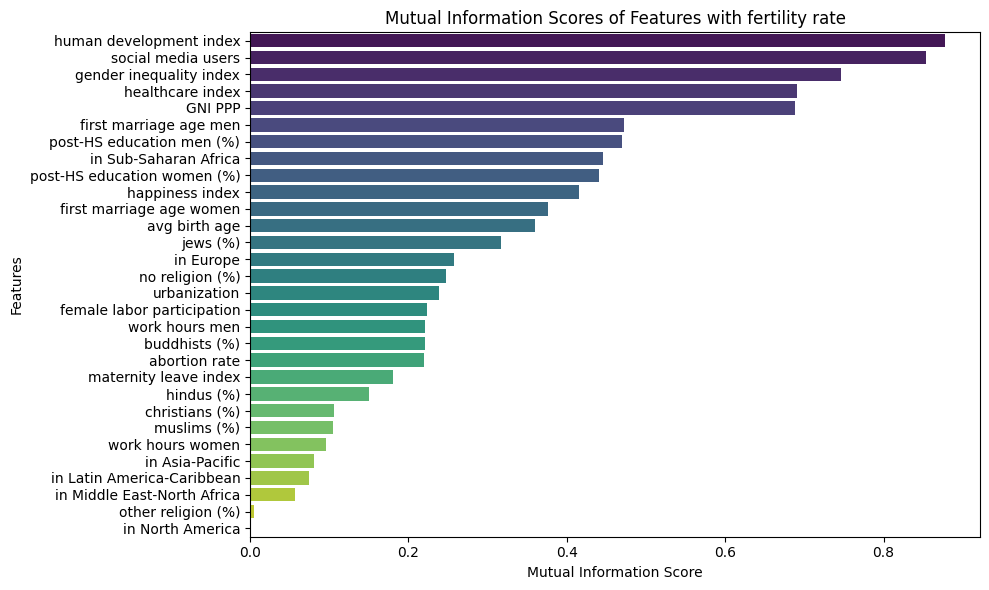


lasso regressor:
Best params: {'lasso__alpha': 0.01}
CV MSE: 0.2748 (±0.5133)
Train accuracy:
MSE: 0.1573
R-squared: 0.9145

coefficients:
human development index: -0.7049
in Sub-Saharan Africa: 0.5656
social media users: -0.3716
gender inequality index: 0.2096
avg birth age: 0.1634
jews (%): 0.1271
happiness index: 0.1270
first marriage age men: -0.1235
work hours men: -0.1127
muslims (%): 0.0952
urbanization: 0.0805
healthcare index: 0.0674
female labor participation: 0.0533
post-HS education men (%): 0.0502
buddhists (%): -0.0499
hindus (%): -0.0349
abortion rate: 0.0321
other religion (%): -0.0221
in Middle East-North Africa: 0.0213
no religion (%): 0.0070
GNI PPP: -0.0000
christians (%): -0.0000
in Europe: -0.0000
in Asia-Pacific: -0.0000
in Latin America-Caribbean: -0.0000
in North America: -0.0000
post-HS education women (%): -0.0000
first marriage age women: -0.0000
maternity leave index: -0.0000
work hours women: -0.0000

ridge regressor:
Best params: {'ridge__alpha': 10}
CV 

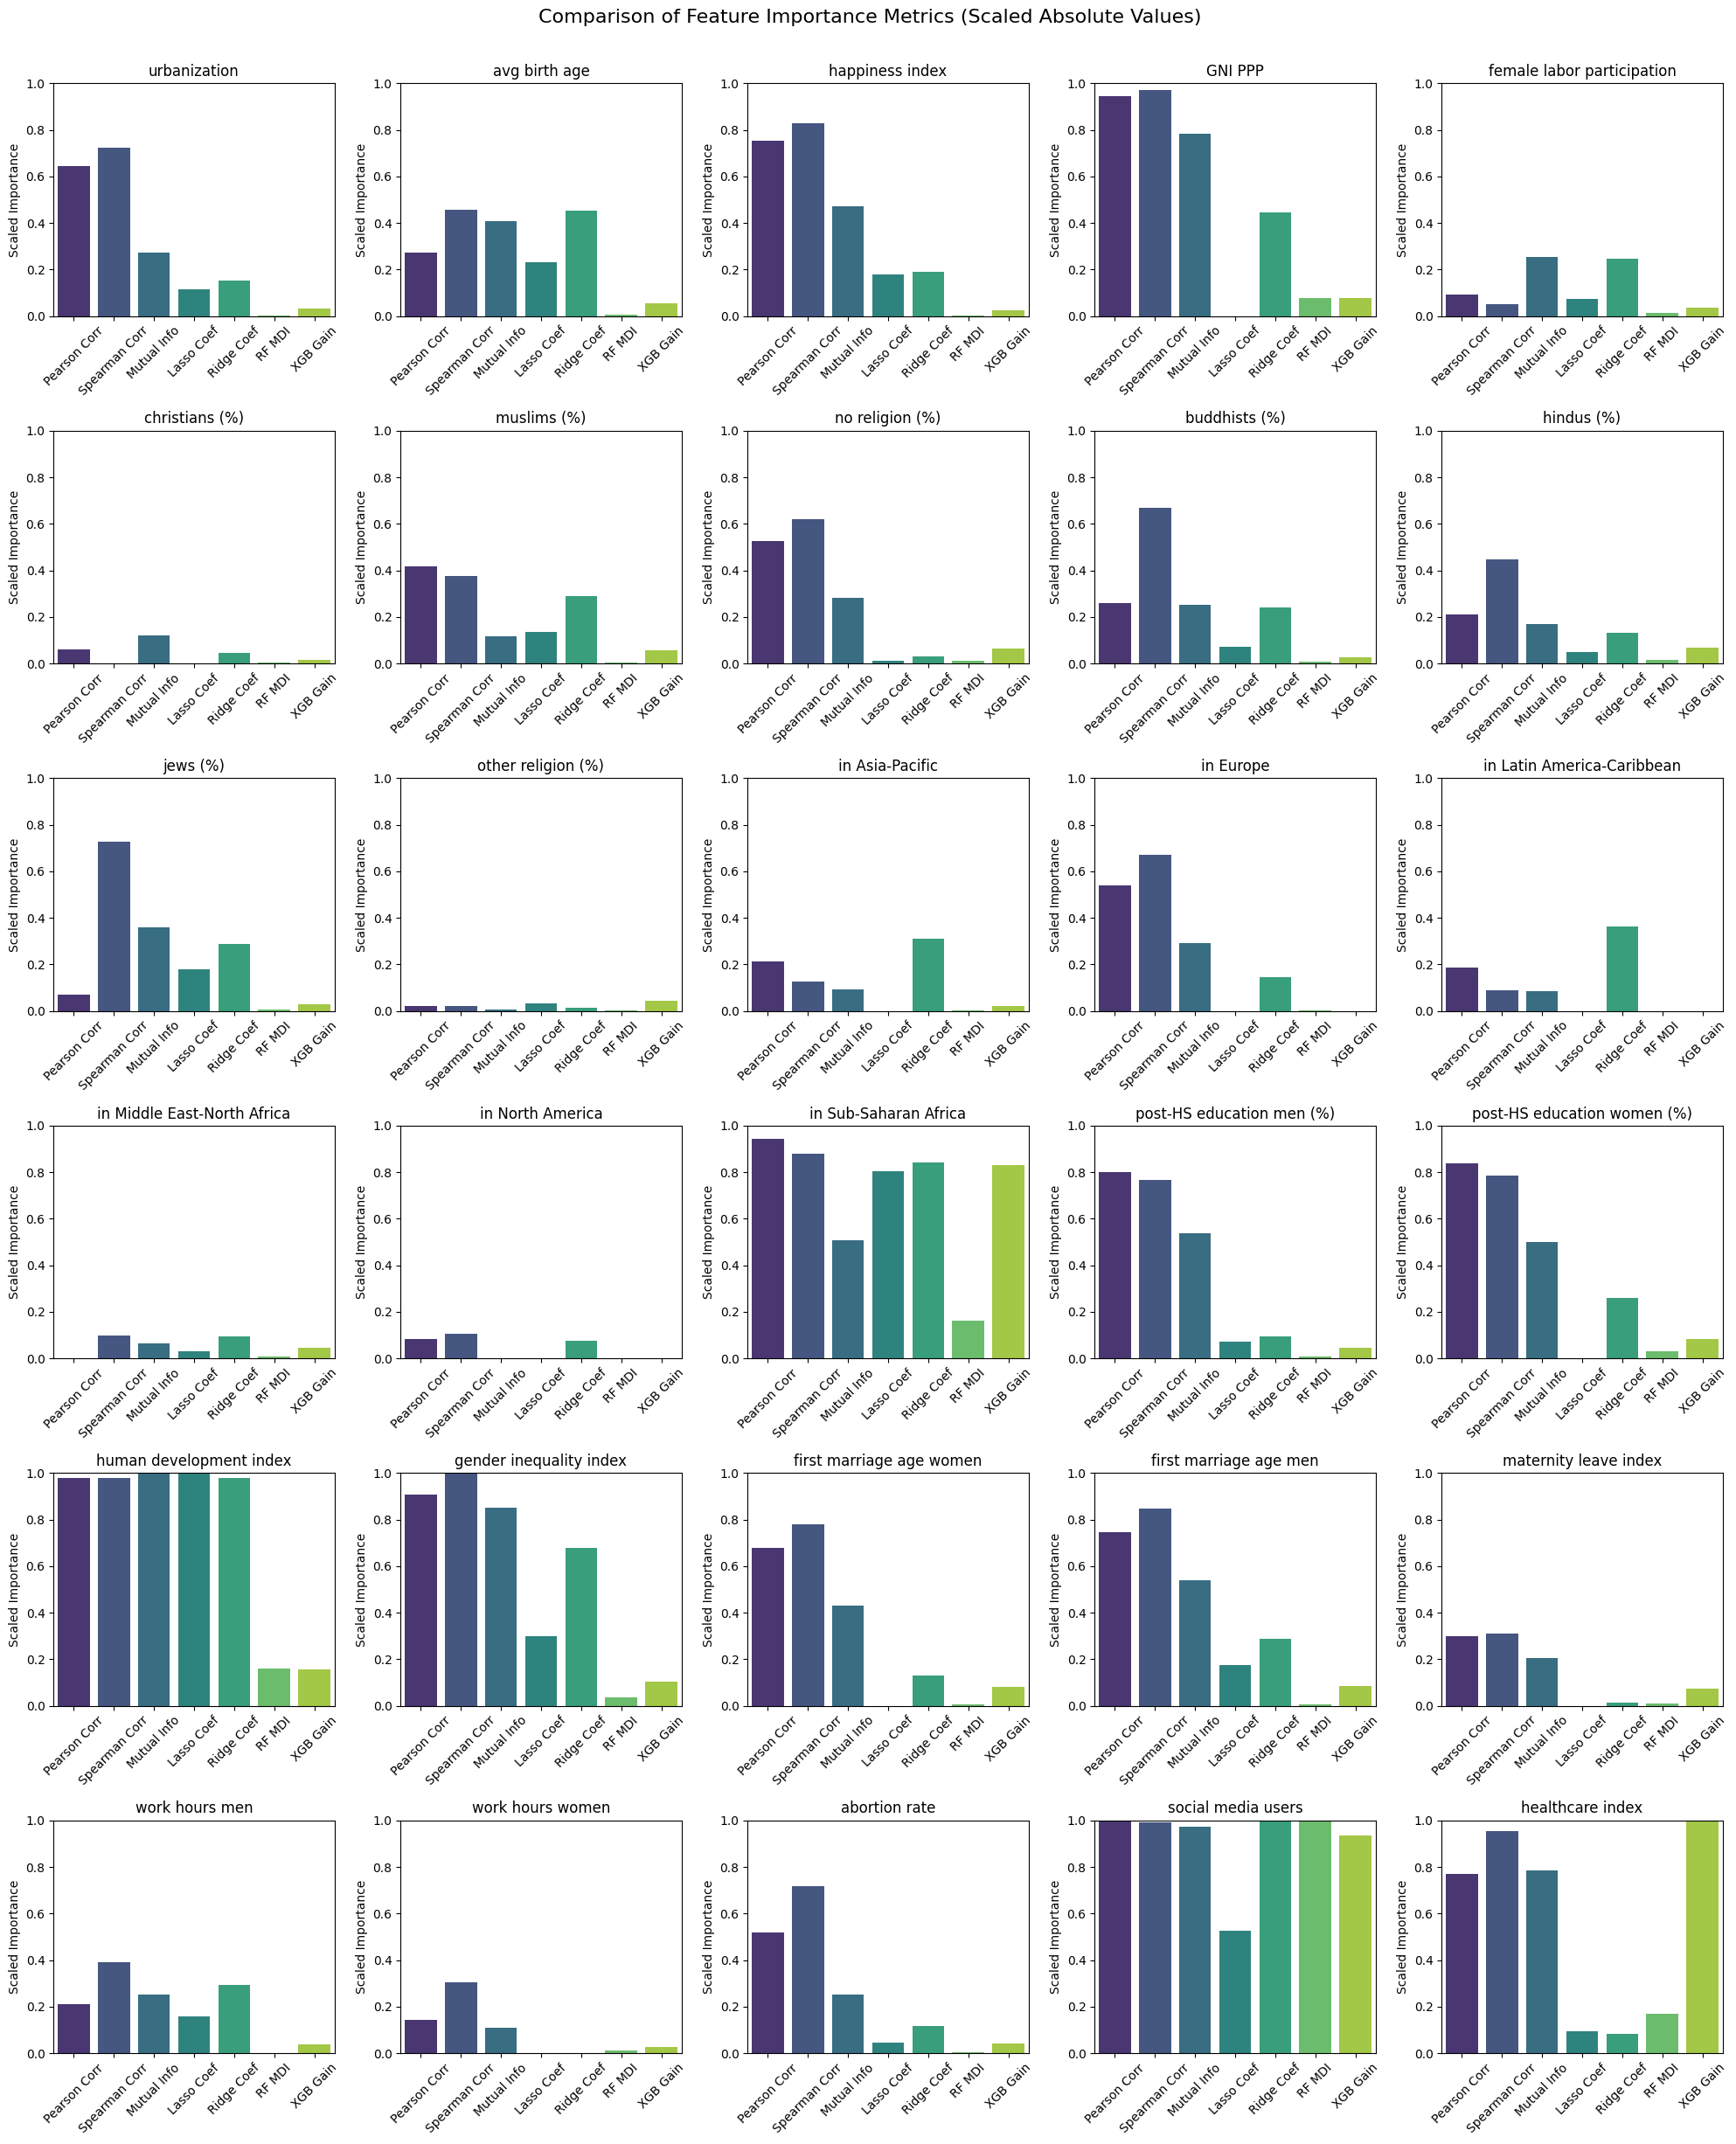

multiple year(1991,2007,2023) data analysis
unscaled features


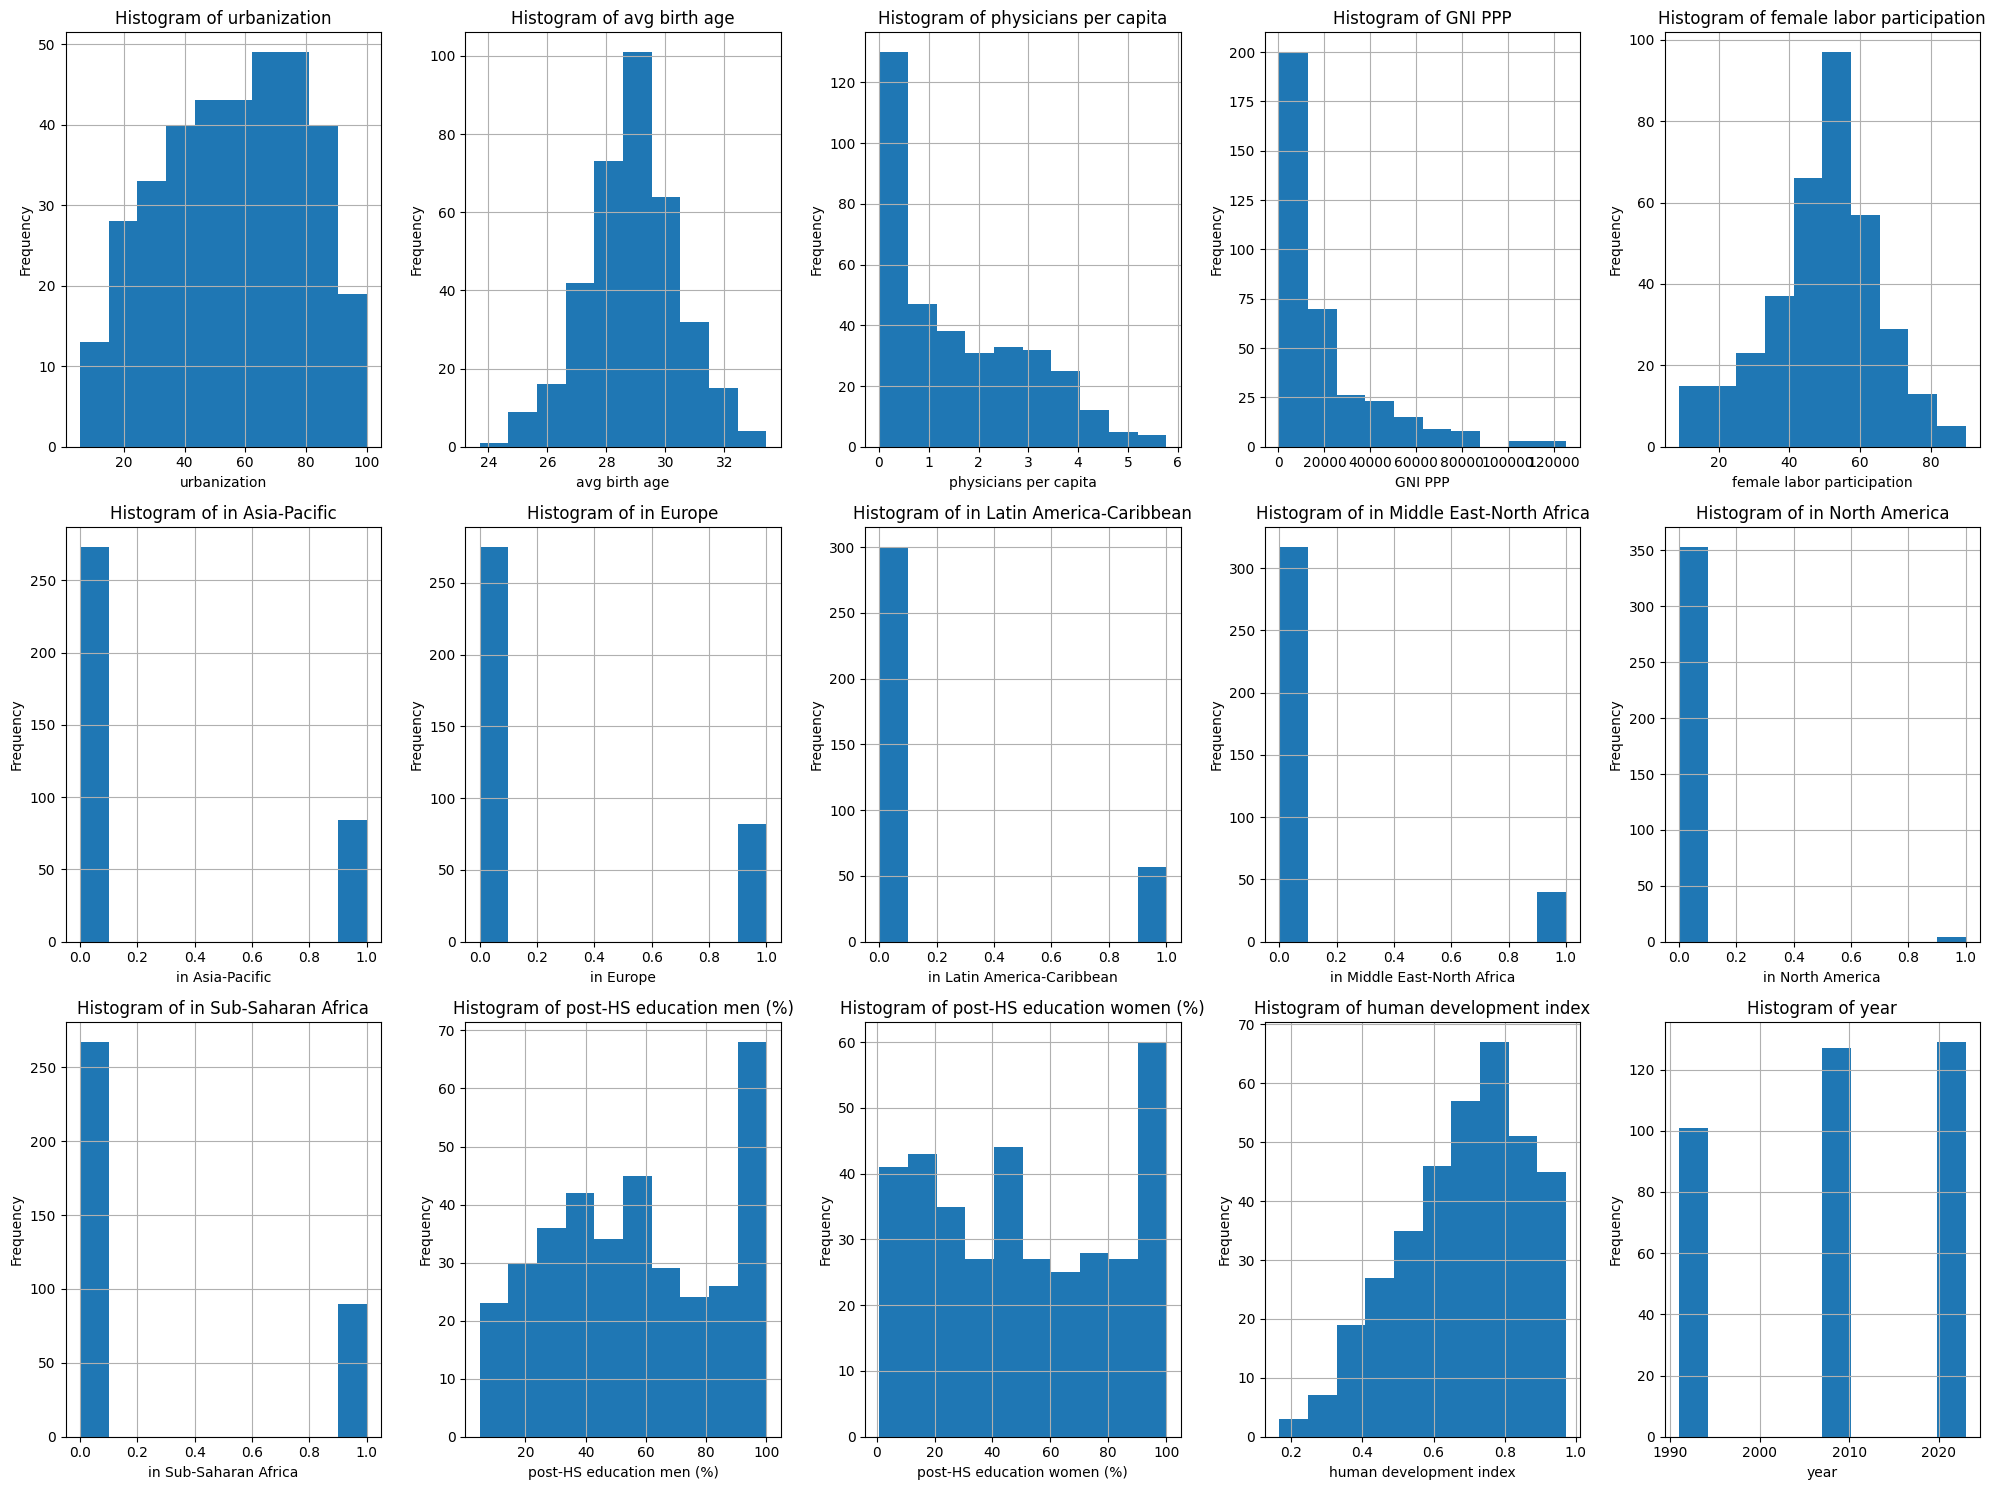

scaled and transformed features


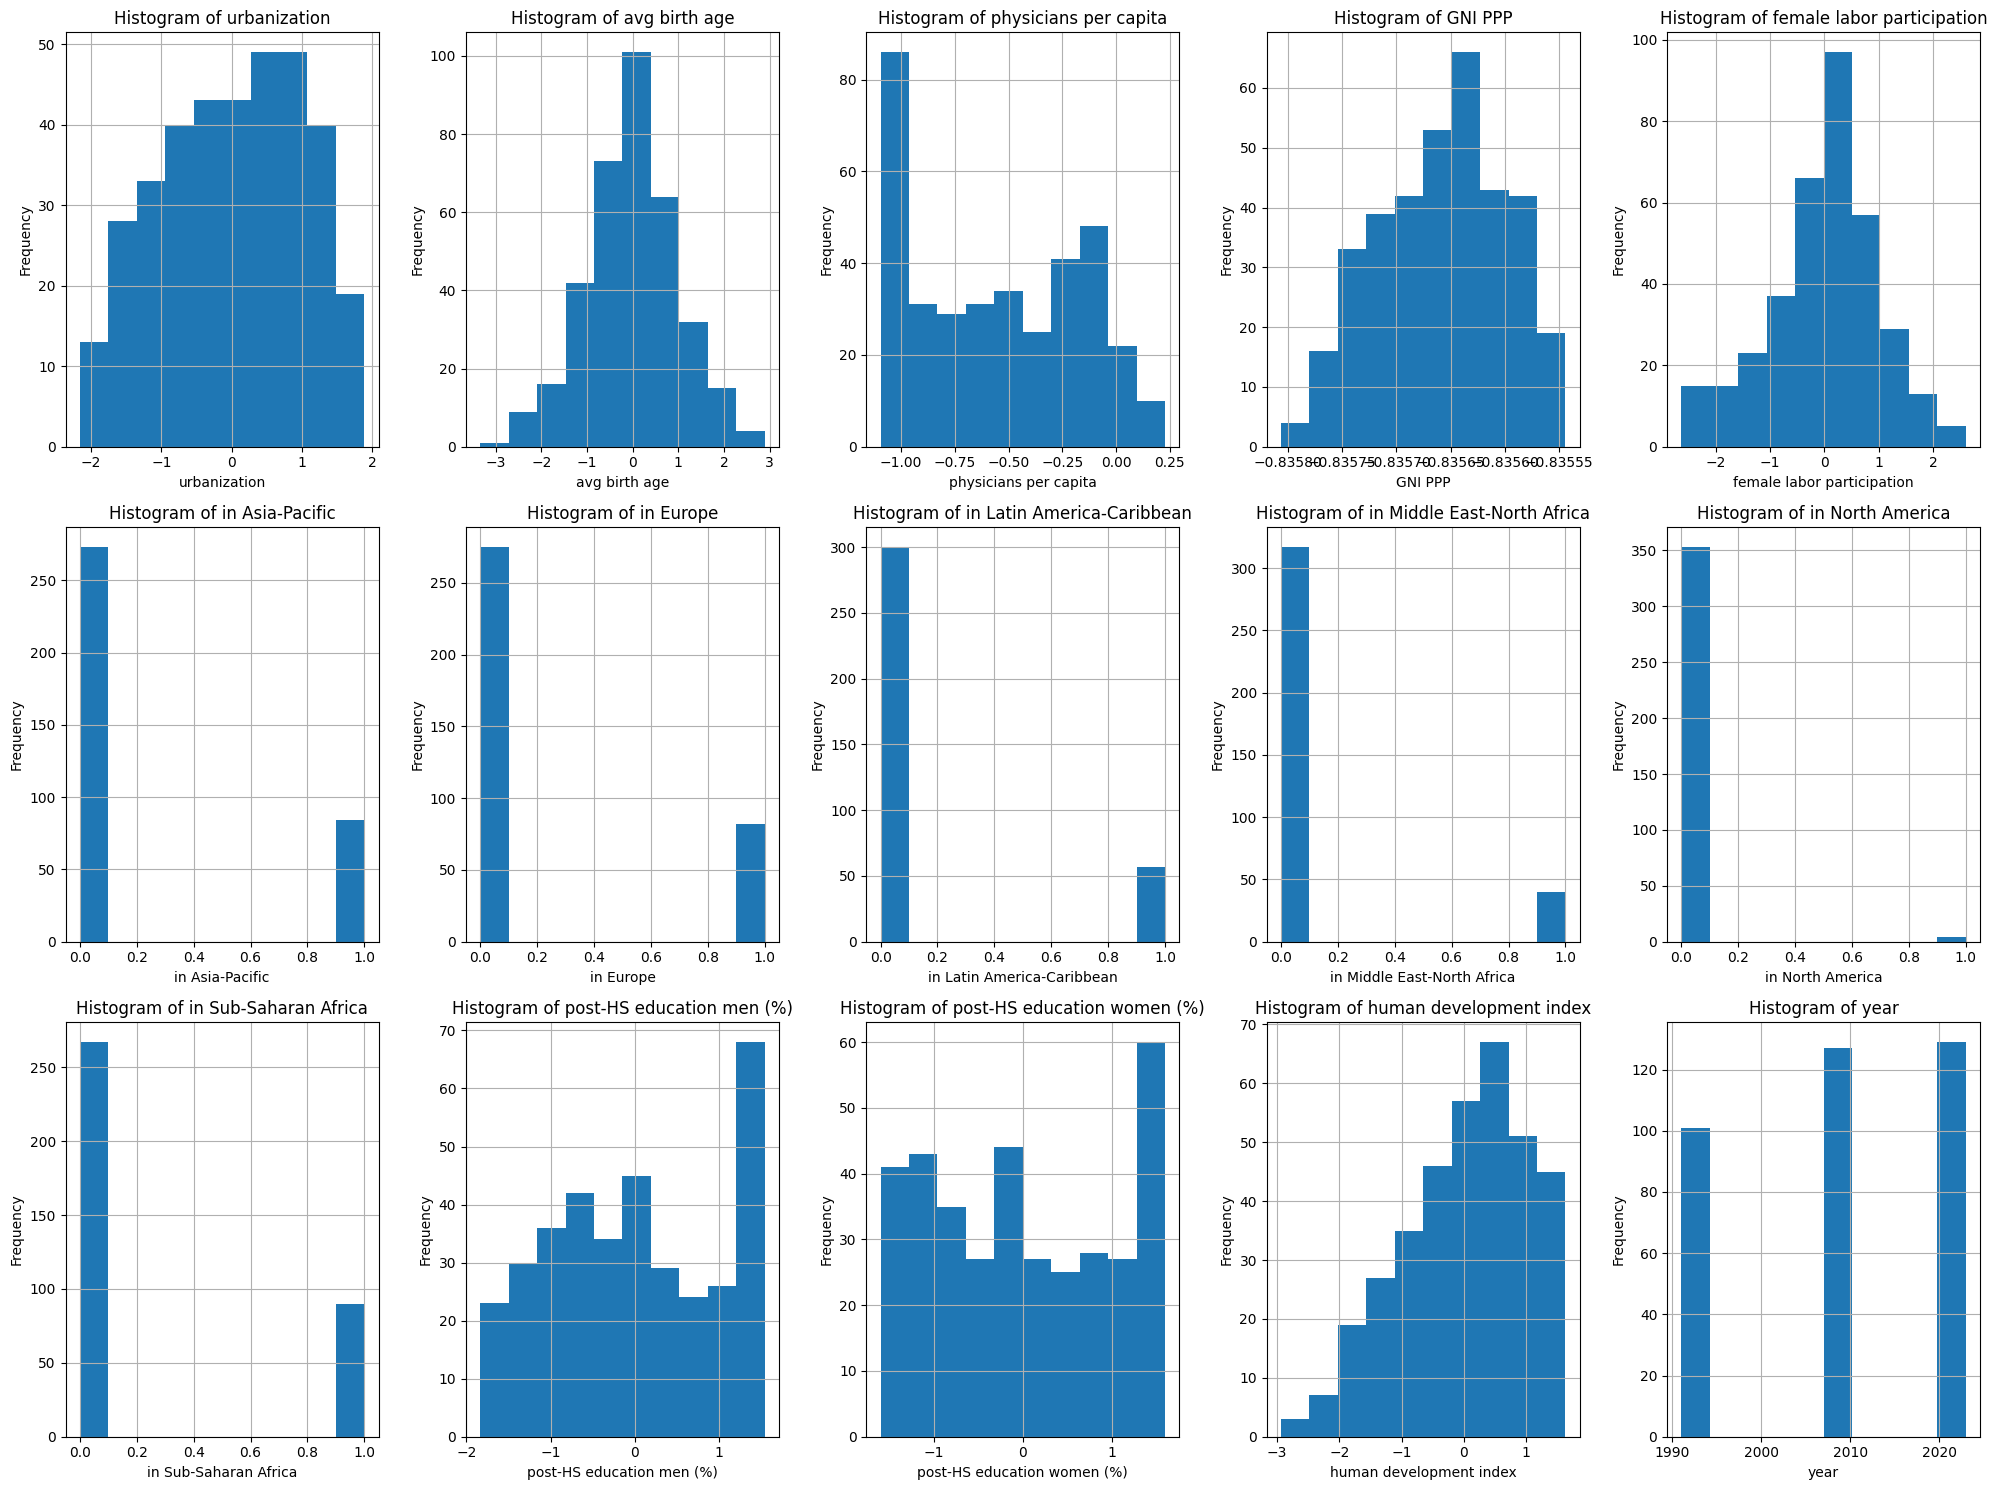


feature pairs correlations:


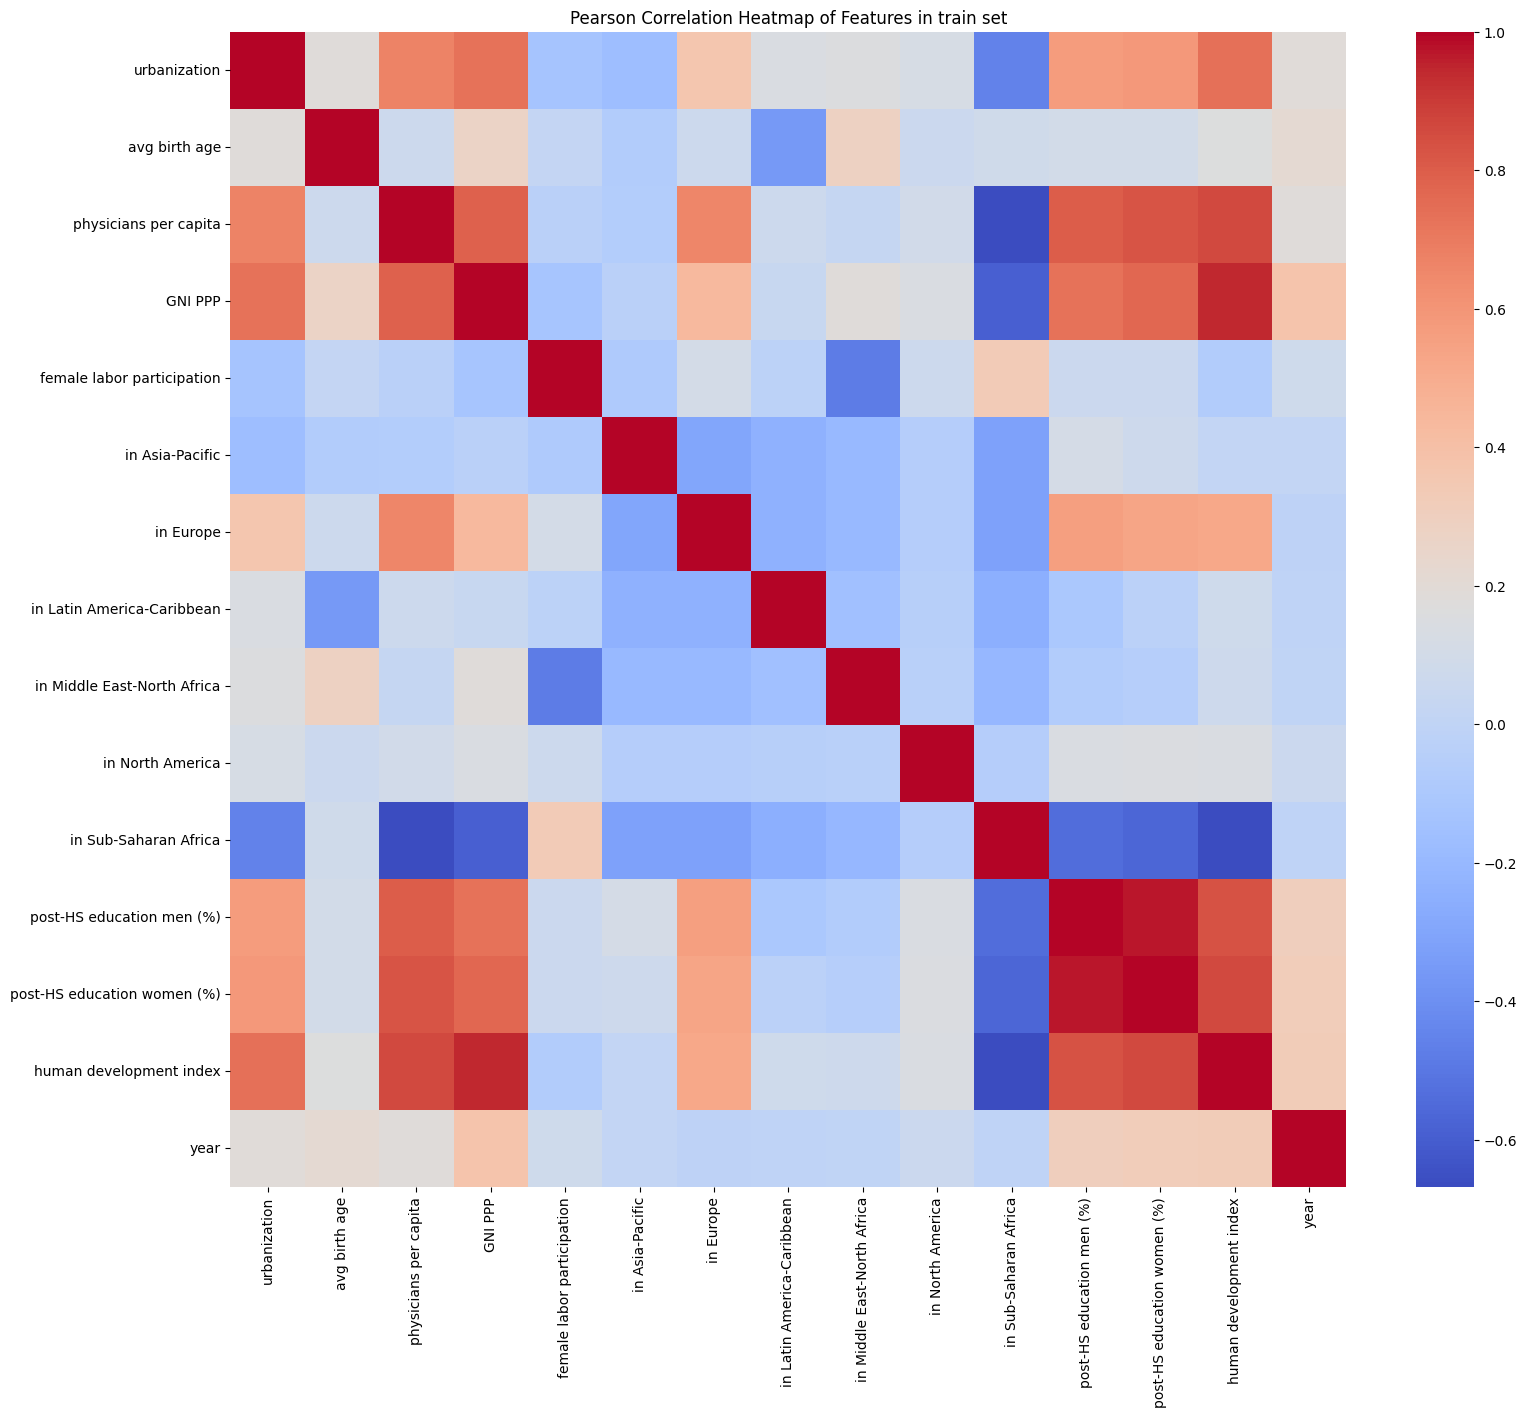


Top 5 most highly correlated pairs of features (absolute Pearson correlation):
  post-HS education men (%) and post-HS education women (%): 0.9720
  GNI PPP and human development index: 0.9415
  physicians per capita and human development index: 0.8589
  post-HS education women (%) and human development index: 0.8587
  post-HS education men (%) and human development index: 0.8332


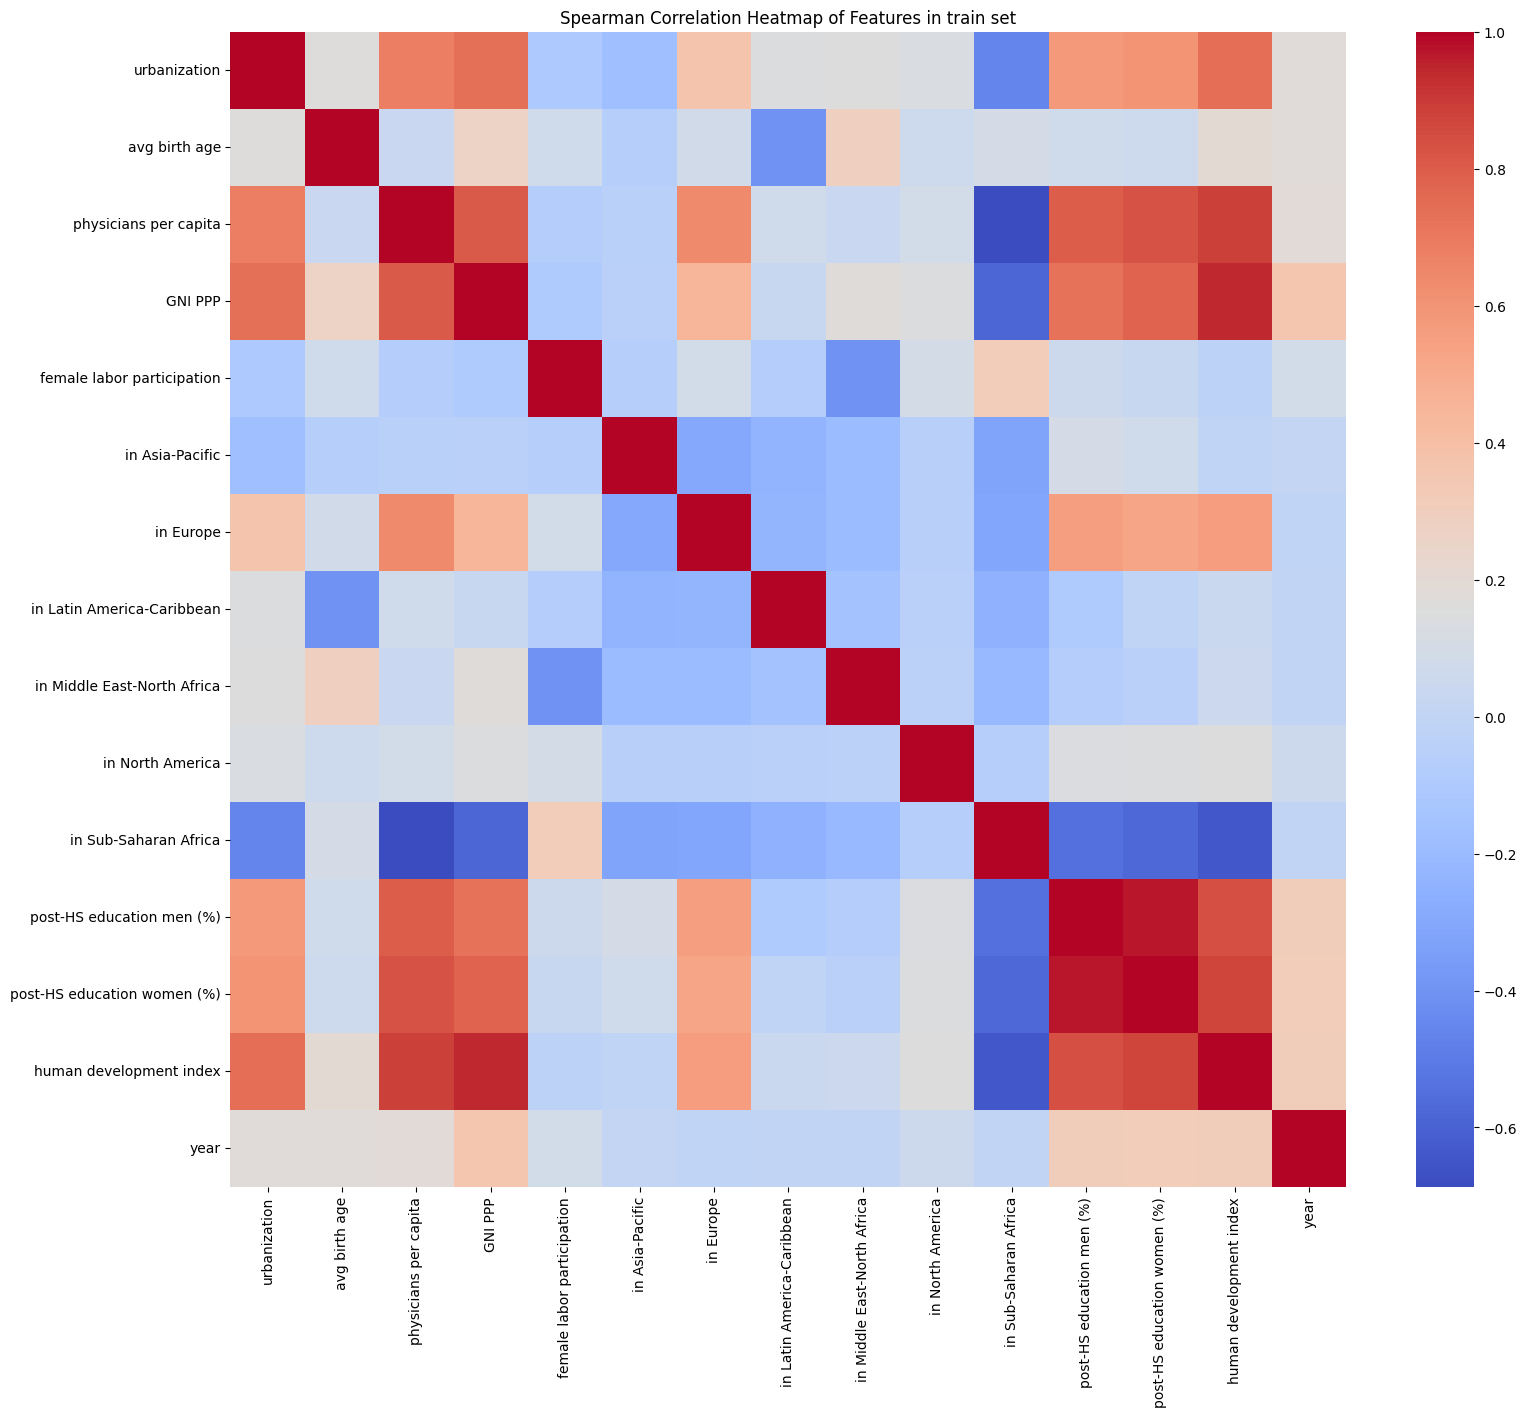


Top 5 most highly correlated pairs of features (absolute Spearman correlation):
  post-HS education men (%) and post-HS education women (%): 0.9708
  GNI PPP and human development index: 0.9461
  physicians per capita and human development index: 0.8838
  post-HS education women (%) and human development index: 0.8724
  post-HS education men (%) and human development index: 0.8354


/tmp/ipython-input-249271996.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


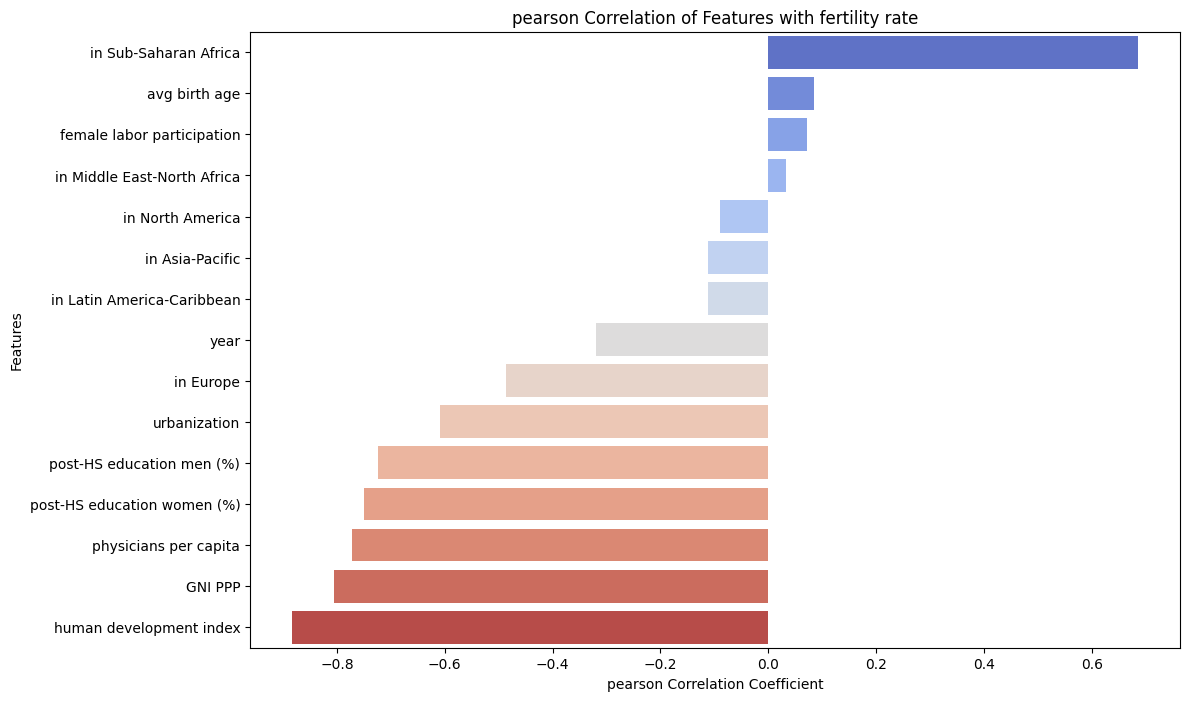


pearson Correlation with fertility rate (with p-values and alpha=0.001):
  in Sub-Saharan Africa: 0.6853 (p<.001)
  avg birth age: 0.0845 (p=0.074)
  female labor participation: 0.0721 (p=0.128)
  in Middle East-North Africa: 0.0329 (p=0.488)
  in North America: -0.0899 (p=0.058)
  in Asia-Pacific: -0.1116 (p=0.018)
  in Latin America-Caribbean: -0.1119 (p=0.018)
  year: -0.3188 (p<.001)
  in Europe: -0.4856 (p<.001)
  urbanization: -0.6086 (p<.001)
  post-HS education men (%): -0.7247 (p<.001)
  post-HS education women (%): -0.7496 (p<.001)
  physicians per capita: -0.7716 (p<.001)
  GNI PPP: -0.8051 (p<.001)
  human development index: -0.8828 (p<.001)


/tmp/ipython-input-249271996.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_series.values, y=correlation_series.index, palette='coolwarm')


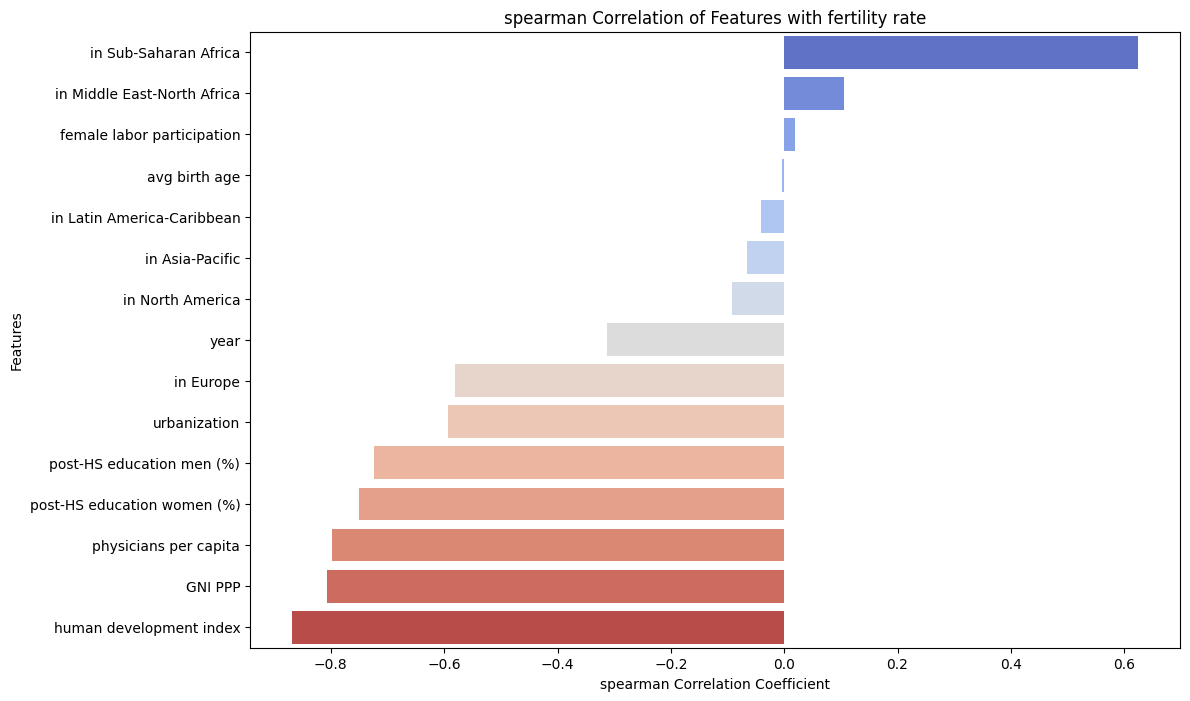


spearman Correlation with fertility rate (with p-values and alpha=0.001):
  in Sub-Saharan Africa: 0.6238 (p<.001)
  in Middle East-North Africa: 0.1048 (p=0.027)
  female labor participation: 0.0197 (p=0.677)
  avg birth age: -0.0046 (p=0.922)
  in Latin America-Caribbean: -0.0408 (p=0.389)
  in Asia-Pacific: -0.0660 (p=0.164)
  in North America: -0.0925 (p=0.051)
  year: -0.3121 (p<.001)
  in Europe: -0.5806 (p<.001)
  urbanization: -0.5936 (p<.001)
  post-HS education men (%): -0.7246 (p<.001)
  post-HS education women (%): -0.7502 (p<.001)
  physicians per capita: -0.7974 (p<.001)
  GNI PPP: -0.8063 (p<.001)
  human development index: -0.8680 (p<.001)
Mutual Information Scores of Features with fertility rate:
human development index        0.791474
GNI PPP                        0.586282
physicians per capita          0.539918
post-HS education women (%)    0.466614
post-HS education men (%)      0.458513
in Europe                      0.264509
in Sub-Saharan Africa          0.256

/tmp/ipython-input-2012191448.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mi_scores.values, y=mi_scores.index, palette='viridis')


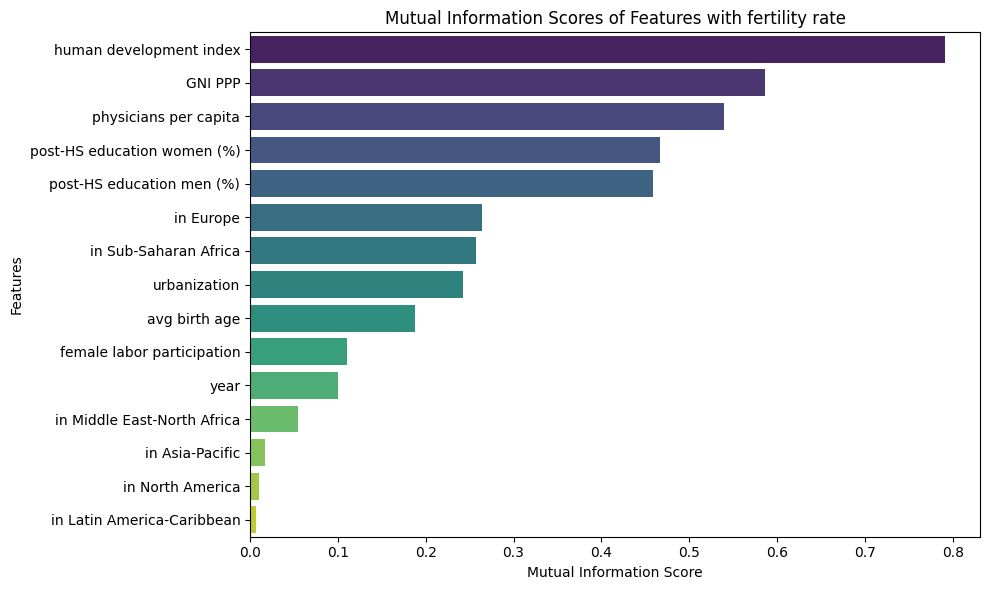


lasso regressor:
Best params: {'lasso__alpha': 0.01}
CV MSE: 0.4057 (±0.6795)
Train accuracy:
MSE: 0.3820
R-squared: 0.8647

coefficients:
human development index: -1.3606
in Sub-Saharan Africa: 0.5047
avg birth age: 0.3562
in Europe: -0.3123
in Asia-Pacific: -0.2797
post-HS education women (%): 0.1314
female labor participation: -0.0413
year: -0.0178
GNI PPP: -0.0000
urbanization: 0.0000
physicians per capita: -0.0000
in North America: 0.0000
in Middle East-North Africa: 0.0000
in Latin America-Caribbean: 0.0000
post-HS education men (%): 0.0000

ridge regressor:
Best params: {'ridge__alpha': 3}
CV MSE: 0.4085 (±0.6848)
Train accuracy:
MSE: 0.3770
R-squared: 0.8664

coefficients:
human development index: -1.3408
in Sub-Saharan Africa: 0.5407
in Europe: -0.3594
avg birth age: 0.3547
in Asia-Pacific: -0.3423
physicians per capita: -0.1935
post-HS education women (%): 0.1726
in North America: 0.0950
in Middle East-North Africa: 0.0555
female labor participation: -0.0529
post-HS educatio

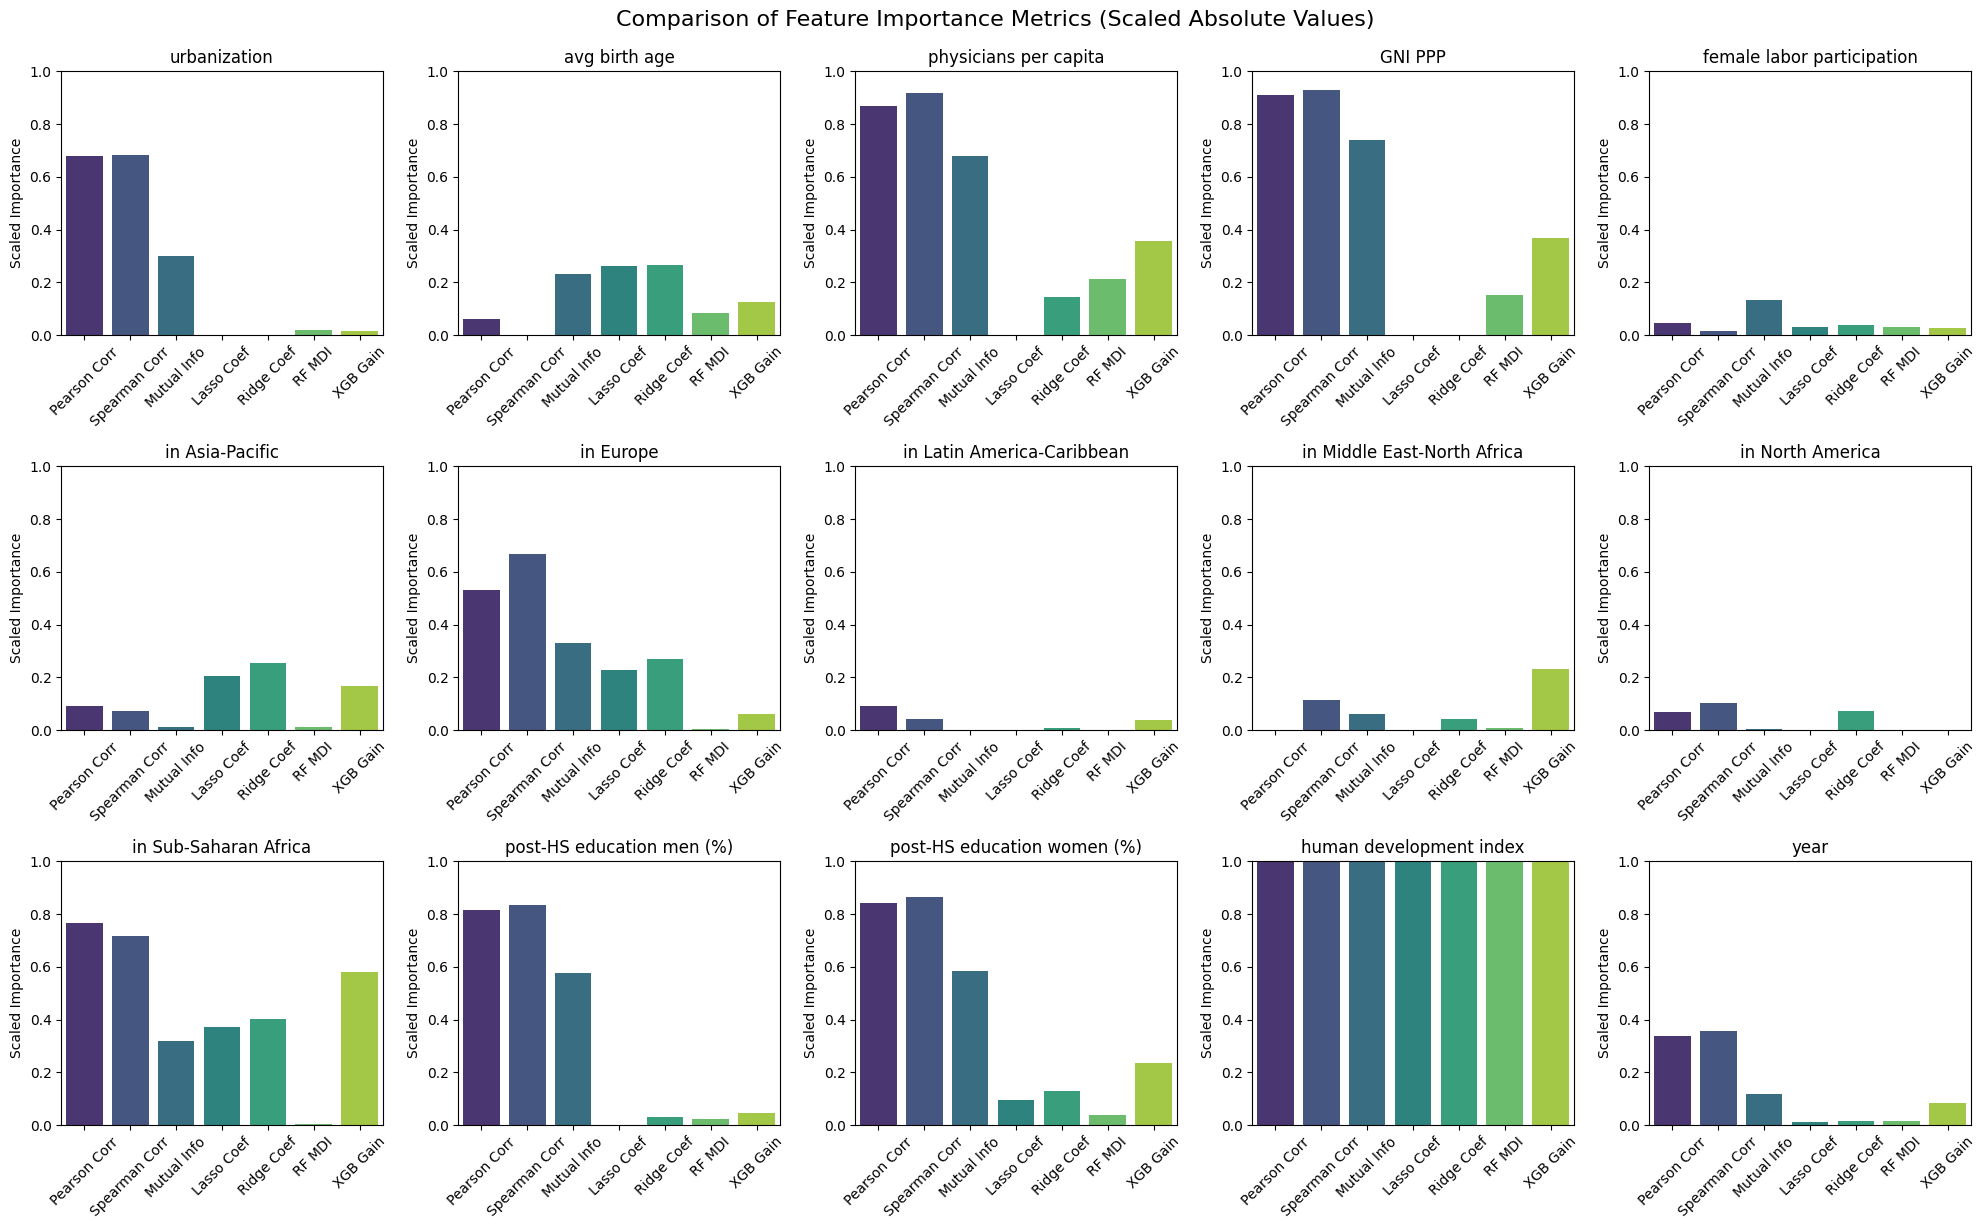

testing the success of models for 2023 country fertility rate on subgroups

lasso regressor:
Best params: {'lasso__alpha': 0.003}
CV MSE: 0.2053 (±0.3651)
Train accuracy:
MSE: 0.1329
R-squared: 0.9262

coefficients:
human development index: -0.8155
in Sub-Saharan Africa: 0.7421
social media users: -0.4255
in Middle East-North Africa: 0.3864
gender inequality index: 0.2894
healthcare index: 0.2838
happiness index: 0.2024
post-HS education men (%): 0.1676
first marriage age women: -0.1561
avg birth age: 0.1421
muslims (%): 0.1115
urbanization: 0.1061
work hours men: -0.0783
abortion rate: 0.0694
other religion (%): -0.0458
female labor participation: 0.0428
hindus (%): -0.0387
no religion (%): 0.0264
christians (%): -0.0260
jews (%): -0.0234
work hours women: -0.0202
in Europe: -0.0154
maternity leave index: 0.0006
in Asia-Pacific: 0.0000
GNI PPP: 0.0000
buddhists (%): -0.0000
post-HS education women (%): -0.0000
in North America: -0.0000
in Latin America-Caribbean: -0.0000
first marriag

In [21]:
data=init_process()
print("2023 data analysis")
X_train_2023, X_test_2023, y_train_2023, y_test_2023, lasso_gs_2023, ridge_gs_2023, rf_gs_2023, xgb_gs_2023 = exec_experiments(data,False)
print("multiple year(1991,2007,2023) data analysis")
X_train_multi, X_test_multi, y_train_multi, y_test_multi, lasso_gs_multi, ridge_gs_multi, rf_gs_multi, xgb_gs_multi = exec_experiments(data,True)
print("testing the success of models for 2023 country fertility rate on subgroups")
test_subgroups(data,False)
print("testing the success of models for multi year country fertility rate on subgroups")
test_subgroups(data,True)
X,y=process_2023_data(data)
test_causal_effects(X,y)